# Analysis, Hypothesis, and Predictions

# Step 1 - Data Cleaning

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
from google.colab import data_table
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score  
plt.rcParams["figure.figsize"] = (20,5)

In [3]:
# Imported CompanyA.csv
CompanyA = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/DatasetA.csv')
# CompanyB = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/DatasetB.csv')
CompanyC = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/DatasetC.csv')

CompanyA = CompanyA[CompanyA['BookingStatus'] == 'Attending']
# CompanyB = CompanyB[CompanyB['BookingStatus'] == 'Attending']
CompanyC = CompanyC[CompanyC['BookingStatus'] == 'Registered']

Company = pd.concat([CompanyA, CompanyC])
# data_table.DataTable(Company)

In [4]:
# #Encoding categorical variables to be able to find correlation
encode = preprocessing.LabelEncoder()

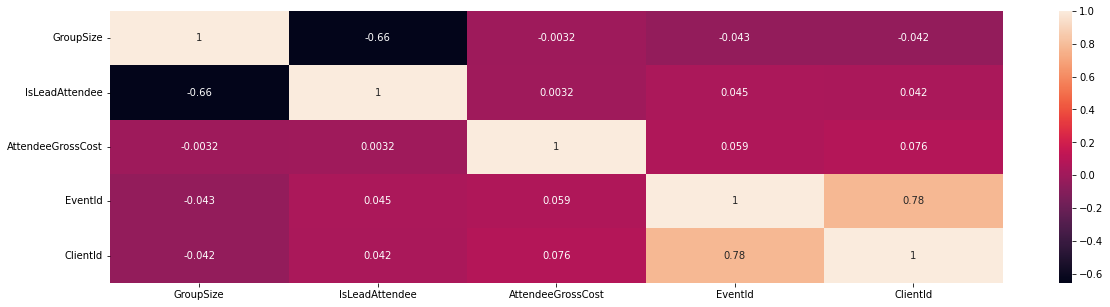

<Figure size 1800x720 with 0 Axes>

In [5]:
#finding correlation to know which columns to drop
# print(CompanyA.corr())
sns.heatmap(Company.corr(), annot = True)
plt.figure(figsize=(25,10))
plt.show()

In [6]:
def event_features(dfs):
    """
    Create time series features based on time series index.
    """
    dfs = dfs.copy()
    dfs['eventdayofweek'] = dfs.StartDate.dt.dayofweek
    dfs['eventquarter'] = dfs.StartDate.dt.quarter
    dfs['eventmonth'] = dfs.StartDate.dt.month
    dfs['eventyear'] = dfs.StartDate.dt.year
    dfs['eventdayofyear'] = dfs.StartDate.dt.dayofyear
    dfs['eventdayofmonth'] = dfs.StartDate.dt.day
    dfs['eventweekofyear'] = dfs.StartDate.dt.isocalendar().week
    return dfs

def booking_features(dfs):
    """
    Create time series features based on time series index.
    """
    dfs = dfs.copy()
    dfs['bookingdayofweek'] = dfs.StatusCreatedDate.dt.dayofweek
    dfs['bookingquarter'] = dfs.StatusCreatedDate.dt.quarter
    dfs['bookingmonth'] = dfs.StatusCreatedDate.dt.month
    dfs['bookingyear'] = dfs.StatusCreatedDate.dt.year
    dfs['bookingdayofyear'] = dfs.StatusCreatedDate.dt.dayofyear
    dfs['bookingdayofmonth'] = dfs.StatusCreatedDate.dt.day
    dfs['bookingweekofyear'] = dfs.StatusCreatedDate.dt.isocalendar().week
    return dfs

In [7]:
#Formating and adding new columns to the dataset
Company['StatusCreatedDate'] = pd.to_datetime(Company['StatusCreatedDate'], infer_datetime_format=True)
Company['StartDate'] = pd.to_datetime(Company['StartDate'], infer_datetime_format=True)
Company['bookingDaysToEvent'] = abs((Company['StartDate'] - Company['StatusCreatedDate']).dt.days)
Company['bookingWeeksToEvent'] = round(Company['bookingDaysToEvent']/7,0)
# Company['bookingweeknumber'] = pd.DatetimeIndex(Company['StatusCreatedDate']).week
# Company['eventWeeknumber'] = pd.DatetimeIndex(Company['StartDate']).week

# To create Season column
_condition_winter = (Company.StartDate.dt.month>=1)&(Company.StartDate.dt.month<=3)
_condtion_spring = (Company.StartDate.dt.month>=4)&(Company.StartDate.dt.month<=6)
_condition_summer = (Company.StartDate.dt.month>=7)&(Company.StartDate.dt.month<=9)
_condition_autumn = (Company.StartDate.dt.month>=10)&(Company.StartDate.dt.month<=12)

Company['EventSeason'] = np.where(_condition_winter,'Winter',np.where(_condtion_spring,'Spring',np.where(_condition_summer,'Summer',np.where(_condition_autumn,'Autumn',np.nan))))

In [8]:
#Encoding the season
Company['SeasonCode'] = encode.fit_transform(Company['EventSeason'])
Company = booking_features(Company)
Company = event_features(Company)

In [9]:
Company.head()
# data_table.DataTable(Company)

EventName           StartDate  \
0  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   
1                                 Queer Homemaking I 2021-10-22 15:00:00   
2  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   
3                                 Queer Homemaking I 2021-10-22 15:00:00   
4  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   

       EventType BookingReference AttendeeReference  GroupSize  \
0        Seminar          B953419          A1021430          1   
1  Reading Group          B954541          A1022562          1   
2        Seminar          B956238          A1024268          1   
3  Reading Group          B959604          A1027663          1   
4        Seminar          B959608          A1027667          1   

   IsLeadAttendee  AttendeeGrossCost  EventId BookingStatus  ...  \
0            True                0.0    24077     Attending  ...   
1            True                0.0    24071     Attending  ...   
2            True                0.0    24077     Attending  ...   
3            True                0.0    24071     Attending  ...   
4            True                0.0    24077     Attending  ...   

  bookingdayofyear bookingdayofmonth bookingweekofyear  eventdayofweek  \
0              123                 3                18               1   
1              215                 3                31               4   
2              276                 3                39               1   
3               75                16                11               4   
4               75                16                11               1   

   eventquarter  eventmonth eventyear  eventdayofyear  eventdayofmonth  \
0             4          10      2021             285               12   
1             4          10      2021             295               22   
2             4          10      2021             285               12   
3             4          10      2021             295               22   
4             4          10      2021             285               12   

   eventweekofyear  
0               41  
1               42  
2               41  
3               42  
4               41  

[5 rows x 32 columns]

# 2. EDA

In [10]:
# Plotting graphs
def ploting(df2, x, y, title="", xlabel='Weeks to event', ylabel='No of tickets sold', dpi=100):
    plt.figure(figsize=(20,5), dpi=dpi)
    plt.plot(x, y, color='tab:red', marker='*')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    # plt.savefig(title, bbox_inches='tight')

In [11]:
#Plotting with numbers as markers
import pylab as pl
def ploting2(df2, x, y, title="", xlabel='Weeks to event', ylabel='No of tickets sold', dpi=100):
    pl.figure(figsize=(20,5), dpi=dpi)
    pl.plot(x, y, marker='*')
    for x, y in zip(x, y):
      pl.text(x, y, str(y), color="red", fontsize=12)
      pl.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    pl.margins(0.1)

# 2.3 EDA Tables

In [17]:
#Selecting related Columns
Company_df2= Company
Company_df2.head()

EventName           StartDate  \
0  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   
1                                 Queer Homemaking I 2021-10-22 15:00:00   
2  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   
3                                 Queer Homemaking I 2021-10-22 15:00:00   
4  Neoliberalism. the Family. and Bourgeois Domes... 2021-10-12 15:00:00   

       EventType BookingReference AttendeeReference  GroupSize  \
0        Seminar          B953419          A1021430          1   
1  Reading Group          B954541          A1022562          1   
2        Seminar          B956238          A1024268          1   
3  Reading Group          B959604          A1027663          1   
4        Seminar          B959608          A1027667          1   

   IsLeadAttendee  AttendeeGrossCost  EventId BookingStatus  ...  \
0            True                0.0    24077     Attending  ...   
1            True                0.0    24071     Attending  ...   
2            True                0.0    24077     Attending  ...   
3            True                0.0    24071     Attending  ...   
4            True                0.0    24077     Attending  ...   

  bookingdayofyear bookingdayofmonth bookingweekofyear  eventdayofweek  \
0              123                 3                18               1   
1              215                 3                31               4   
2              276                 3                39               1   
3               75                16                11               4   
4               75                16                11               1   

   eventquarter  eventmonth eventyear  eventdayofyear  eventdayofmonth  \
0             4          10      2021             285               12   
1             4          10      2021             295               22   
2             4          10      2021             285               12   
3             4          10      2021             295               22   
4             4          10      2021             285               12   

   eventweekofyear  
0               41  
1               42  
2               41  
3               42  
4               41  

[5 rows x 32 columns]

In [18]:
# result = Company_df2.groupby('StartDate')['bookingWeeksToEvent'].aggregate(['min','max'])
min_result = Company_df2.groupby(['StartDate', 'EventSeason', 'SeasonCode', 'EventId']).aggregate({'GroupSize':'sum','bookingWeeksToEvent':'min'}).reset_index()
min_result.columns = ['StartDate', 'Season', 'SeasonCode', 'EventId', 'TotalTickets', 'LastbookingWeek']
# print(min_result)

max_result = Company_df2.groupby(['StartDate','EventSeason', 'SeasonCode', 'EventId']).aggregate({'GroupSize':'sum', 'bookingWeeksToEvent':'max'}).reset_index()
max_result.columns = ['StartDate2', 'Season2', 'SeasonCode2', 'EventId2', 'TotalTickets2', 'FirstbookingWeek']
# print(max_result)

result_df = pd.concat([min_result, max_result], axis=1, join="inner")

result_df['TotalWeeksToSell'] = result_df['FirstbookingWeek'] - result_df['LastbookingWeek']
result_df.drop(columns=['StartDate2', 'TotalTickets2', 'Season2', 'SeasonCode2', 'EventId2'], inplace=True)

result_df['EventDate'] = result_df['StartDate'].dt.date
# result_df['SeasonCode'] = encode.fit_transform(result_df['Season'])

# result_df = event_features(result_df)

# result_df.set_index('EventDate', inplace=True)


In [19]:
result_df = event_features(result_df)
result_df = result_df.astype({'eventdayofweek': 'int', 'eventquarter':'int', 'eventmonth':'int', 'eventyear':'int' ,'eventdayofyear':'int','eventdayofmonth':'int','eventweekofyear':'int'})
print(result_df)

               StartDate  Season  SeasonCode  EventId  TotalTickets  \
0    2017-05-12 00:00:00  Spring           1    15005            64   
1    2017-07-12 00:00:00  Summer           2    15029          1005   
2    2017-08-12 00:00:00  Summer           2    15019           145   
3    2017-11-25 00:00:00  Autumn           0    14912           338   
4    2017-11-25 00:00:00  Autumn           0    14948           324   
...                  ...     ...         ...      ...           ...   
1888 2022-12-05 17:45:00  Autumn           0    24692            46   
1889 2022-12-07 15:00:00  Autumn           0    26281             7   
1890 2022-12-15 15:00:00  Autumn           0    27225             4   
1891 2023-01-13 10:00:00  Winter           3    27545             1   
1892 2023-01-17 14:30:00  Winter           3    27368             6   

      LastbookingWeek  FirstbookingWeek  TotalWeeksToSell   EventDate  \
0                 4.0              29.0              25.0  2017-05-12   
1

In [20]:
sesonCodes = result_df['SeasonCode'].unique()
seasonDecodes = encode.inverse_transform(result_df['SeasonCode'].unique())
seasonMap ={}
i=0
for i in range(0, len(sesonCodes)):
  seasonMap[seasonDecodes[i]] = sesonCodes[i]
  i+1

print(seasonMap)
# seasonMap = map(result_df['SeasonCode'].unique(), encode.inverse_transform(result_df['SeasonCode'].unique()))

{'Spring': 1, 'Summer': 2, 'Autumn': 0, 'Winter': 3}


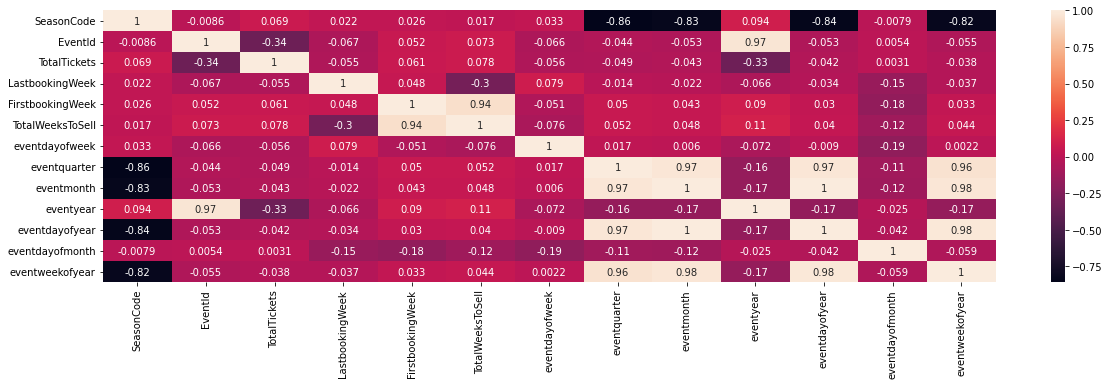

In [21]:
sns.heatmap(result_df.corr(), annot = True)
plt.show()

# 3. Hypothesis and Correlations

Correlation between first booking week and total weeks to sell

In [22]:
#Correlation between first booking week and total weeks to sell out
np.corrcoef(result_df['FirstbookingWeek'], result_df['TotalWeeksToSell'])

# -1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

#Positive correlation

array([[1.        , 0.93706316],
       [0.93706316, 1.        ]])

Correlation between first booking week and total tickets eventually sold

In [23]:
#Correlation between first booking week and total tickets eventually sold
np.corrcoef(result_df['FirstbookingWeek'], result_df['TotalTickets'])

# -1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

#No linear correlation

array([[1.        , 0.06127988],
       [0.06127988, 1.        ]])

In [24]:
from scipy.stats.stats import pearsonr
pearsonr(result_df['FirstbookingWeek'], result_df['TotalTickets'])
#P-Value is greater than 0.05, which means there is not significant correlation
#Meaning, when the ticket sales start doesnt have significant correlation with how many tickets were eventually sold

<ipython-input-24-e9999901e6a5>:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=0.061279882196820436, pvalue=0.007654337703196026)

Correlation between total weeks to sell and total tickets eventually sold


In [25]:
#Correlation between total weeks to sell and total tickets eventually sold
np.corrcoef(result_df['TotalWeeksToSell'], result_df['TotalTickets'])

# -1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

#No linear correlation

array([[1.        , 0.07783005],
       [0.07783005, 1.        ]])

In [26]:
pearsonr(result_df['TotalWeeksToSell'], result_df['TotalTickets'])
#P-Value is greater than 0.05, which means there is not significant correlation
#Meaning, when the ticket sales start doesnt have significant correlation with how many tickets were eventually sold

PearsonRResult(statistic=0.07783005352710749, pvalue=0.0007010113031608001)

Correlation between last booking week and total tickets sold

In [27]:
#Correlation between first booking week and total tickets eventually sold
np.corrcoef(result_df['LastbookingWeek'], result_df['TotalTickets'])

# -1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

#No linear correlation

array([[ 1.        , -0.05542149],
       [-0.05542149,  1.        ]])

Correlation between season and total tickets sold

In [28]:
# np.corrcoef(result_df['SeasonCode'], result_df['TotalTickets'])
np.corrcoef(result_df['SeasonCode'], result_df['TotalTickets'])
#Correlation

array([[1.        , 0.06857996],
       [0.06857996, 1.        ]])

In [29]:
pearsonr(result_df['SeasonCode'], result_df['TotalTickets'])

PearsonRResult(statistic=0.06857996439062132, pvalue=0.002832411638046219)

OLS to find correlation between first booking week and total tickets eventually sold

In [30]:
import statsmodels.api as sm
#define predictor and response variables
y = result_df['TotalTickets']
x = result_df[['FirstbookingWeek']]
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

#P-Value is greater than 0.05, which means there is not significant correlation
#Meaning when the ticket sales start doesnt have significant correlation with how many tickets were eventually sold

                            OLS Regression Results                            
Dep. Variable:           TotalTickets   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     7.128
Date:                Sat, 04 Mar 2023   Prob (F-statistic):            0.00765
Time:                        15:07:09   Log-Likelihood:                -14424.
No. Observations:                1893   AIC:                         2.885e+04
Df Residuals:                    1891   BIC:                         2.886e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               98.5476     27.265  

OLS to find correlation between Total weeks to sell and total tickets eventually sold

In [31]:
#Correlation between Total weeks to sell and total tickets eventually sold
import statsmodels.api as sm
#define predictor and response variables
y = result_df['TotalTickets']
x = result_df[['TotalWeeksToSell']]
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())


#P-Value is greater than 0.05, which means there is not significant correlation
#Meaning when the total number of weeks to settl the ticket sales doesnt have significant correlation with how many tickets were eventually sold

                            OLS Regression Results                            
Dep. Variable:           TotalTickets   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     11.52
Date:                Sat, 04 Mar 2023   Prob (F-statistic):           0.000701
Time:                        15:07:09   Log-Likelihood:                -14421.
No. Observations:                1893   AIC:                         2.885e+04
Df Residuals:                    1891   BIC:                         2.886e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               88.5128     25.150  

ANOVA for season vs total tickets sold

In [32]:
#Perform one-way ANOVA on categorical variables - Event season and the total tickets sold
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('TotalTickets ~ C(SeasonCode)', data=result_df).fit()
a=sm.stats.anova_lm(model, typ=1)

print('ANOVA Test Results')
print(a)

ANOVA Test Results
                   df        sum_sq        mean_sq         F   PR(>F)
C(SeasonCode)     3.0  2.571843e+06  857281.069148  3.526358  0.01441
Residual       1889.0  4.592285e+08  243106.666280       NaN      NaN


ANOVA for Start date and first week booking vs total tickets sold

In [33]:
#Perform one-way ANOVA on categorical variables - Event start date and first booking week
import statsmodels.api as sm
from statsmodels.formula.api import ols
model = ols('TotalTickets ~ C(StartDate) + C(FirstbookingWeek)', data=result_df).fit()
a=sm.stats.anova_lm(model, typ=2)

print('ANOVA Test Results')
print(a)

ANOVA Test Results
                           sum_sq      df         F    PR(>F)
C(StartDate)         3.316055e+08  1310.0  1.231451  0.002727
C(FirstbookingWeek)  1.256248e+07    74.0  0.825867  0.845512
Residual             1.062732e+08   517.0       NaN       NaN


In [34]:
# f_oneway() function takes the group data as input and 
# returns F-statistic and P-value
from scipy.stats import f_oneway
# Finds out the total tickets for each season as a list
CategoryGroupLists=result_df.groupby('Season')['TotalTickets'].apply(list)
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value <= 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.014409946652796468


ANOVA for season vs total tickets sold

In [35]:
# f_oneway() function takes the group data as input and 
# returns F-statistic and P-value
from scipy.stats import f_oneway
# Finds out the total tickets for each season as a list
CategoryGroupLists=result_df.groupby('Season')['TotalTickets'].apply(list)
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value <= 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  0.014409946652796468


For the season against the number of tickets sold, the p-value is less than the significant level (0.05) which means season affects the possible total number of ticket to be sold

ANOVA for season vs total weeks to sell

In [36]:
from scipy.stats import f_oneway
# Finds out the total tickets for each season as a list
CategoryGroupLists=result_df.groupby('Season')['TotalWeeksToSell'].apply(list)
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value <= 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  4.661317501822543e-40


For the season against the number of weeks to sell, the p-value is less than the significant level (0.05) which means season affects the total number of weeks to sell out your tickets

ANOVA for season vs First booking week

In [37]:
from scipy.stats import f_oneway
# Finds out the total tickets for each season as a list
CategoryGroupLists=result_df.groupby('Season')['FirstbookingWeek'].apply(list)
# Performing the ANOVA test
# We accept the Assumption(H0) only when P-Value <= 0.05
AnovaResults = f_oneway(*CategoryGroupLists)
print('P-Value for Anova is: ', AnovaResults[1])

P-Value for Anova is:  5.646705555645479e-47


# Predictions

In [38]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set   
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False, stratify=None) 

train, test = train_test_split(result_df, shuffle=False, test_size=0.1)

In [39]:
train.columns

Index(['StartDate', 'Season', 'SeasonCode', 'EventId', 'TotalTickets',
       'LastbookingWeek', 'FirstbookingWeek', 'TotalWeeksToSell', 'EventDate',
       'eventdayofweek', 'eventquarter', 'eventmonth', 'eventyear',
       'eventdayofyear', 'eventdayofmonth', 'eventweekofyear'],
      dtype='object')

# ARIMA Predicion - Total Ticket bookings

            TotalTickets  LastbookingWeek  FirstbookingWeek
StartDate                                                  
2017-05-14          64.0              4.0              29.0
2017-07-16        1005.0             13.0              26.0
2017-08-13         145.0              4.0              30.0
2017-11-26         262.0              0.0              25.0
2017-12-03         806.0              0.0              27.0


<AxesSubplot:title={'center':'Average weekly ticket purhcase per event'}, xlabel='Event Dates', ylabel='Weeks to event booking'>

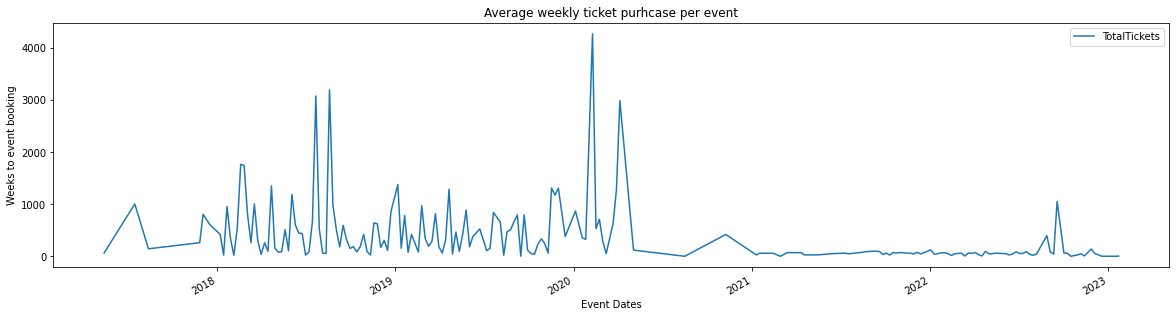

In [40]:
#ARIMA for total ticket puchased
tickets_arima_df = result_df[['StartDate', 'TotalTickets', 'LastbookingWeek', 'FirstbookingWeek']].set_index('StartDate')

tickets_arima_df = tickets_arima_df.groupby([pd.Grouper(level='StartDate', freq='W')]).mean()#.reset_index()

#dropping rows with Null values
tickets_arima_df.dropna(inplace=True)

print(tickets_arima_df.head())

#Plotting arima_df with average week num
tickets_arima_df['TotalTickets'].plot(legend=True, figsize=(20,5), xlabel = 'Event Dates', ylabel='Weeks to event booking', title='Average weekly ticket purhcase per event')

In [41]:
#Checking for staionarity before differencing to prevent over differentiation
from statsmodels.tsa.stattools import adfuller

sta_test = adfuller(tickets_arima_df['TotalTickets'], autolag = 'AIC')
print('1. ADF:' , sta_test[0])
print('2. P-Value:' , sta_test[1]) # data set not stationary null-hypothesis is true because it is greater than 0.05
print('3. Num of Lags:' , sta_test[2])
print('4. Num of observations used for ADF Regression and critical values calculation:' , sta_test[3])
print('5. Critival values:')
for key, val in sta_test[4].items():
  print('\t', key, " : ", val)

1. ADF: -2.556107670340246
2. P-Value: 0.10241241608161944
3. Num of Lags: 6
4. Num of observations used for ADF Regression and critical values calculation: 185
5. Critival values:
	 1%  :  -3.4662005731940853
	 5%  :  -2.8772932777920364
	 10%  :  -2.575167750182615


<AxesSubplot:title={'center':'Average demand per week after differencing'}, xlabel='Week', ylabel='Average Demand'>

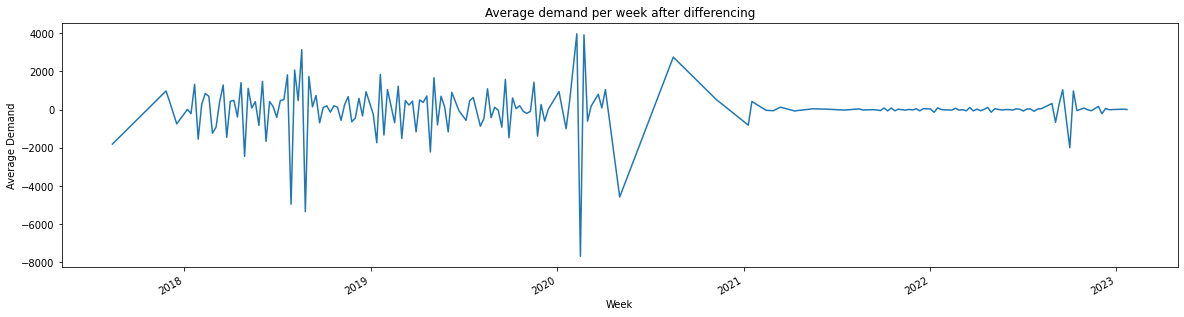

In [42]:
#differencing to make data stationary
tickets_arima_df['TotalTickets'] = tickets_arima_df.diff().diff().TotalTickets

#dropping rows with Null values
tickets_arima_df.dropna(inplace=True)

#Plotting arima_df with average week num
tickets_arima_df['TotalTickets'].plot(figsize=(20,5), xlabel = 'Week', ylabel='Average Demand', title='Average demand per week after differencing')

In [43]:
#install this module to get the best order for the ARIMA model
#install this before importing the pmdarima module
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.9 MB/s eta 0:00:00


In [44]:
#Figuring out order for arima model and lookimg for the best arima model to train with (ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec)
from pmdarima import auto_arima
stepwise_fit = auto_arima(tickets_arima_df['TotalTickets'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3243.717, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3157.935, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3241.720, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3122.905, Time=0.05 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3080.628, Time=0.10 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3056.993, Time=0.13 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=3048.814, Time=0.27 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.85 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=3046.815, Time=0.08 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=3054.995, Time=0.12 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.82 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=1.01 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  190
Model:               SARIMAX(5, 0, 0)   Log Likelihood               -1517.408
Date:                Sat, 04 Mar 2023   AIC                           3046.815
Time:                        15:07:56   BIC                           3066.298
Sample:                             0   HQIC                          3054.707
                                - 190                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3057      0.035    -36.919      0.000      -1.375      -1.236
ar.L2         -1.2999      0.062    -21.028      0.000      -1.421      -1.179
ar.L3         -1.0850      0.063    -17.320      0.000      -1.208      -0.962
ar.L4         -0.6329      0.073     -8.637      0.000      -0.777      -0.489
ar.L5         -0.2271      0.040     -5.745      0.000      -0.305      -0.150
sigma2      5.058e+05   2.27e+04     22.305      0.000    4.61e+05     5.5e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):               774.29
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               0.05   Skew:                             1.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
#Fitting the arima model and spliting data into train and test
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train, test = train_test_split(tickets_arima_df, shuffle=False, test_size=0.2)

#training with the best arima model gotten above - ARIMA(0,1,3)(0,0,0)[0]      
tickets_arima = ARIMA(train['TotalTickets'], order=(0,1,1))
tickets_arima  = tickets_arima.fit()
tickets_arima.summary()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           TotalTickets   No. Observations:                  152
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1304.776
Date:                Sat, 04 Mar 2023   AIC                           2613.552
Time:                        15:07:56   BIC                           2619.587
Sample:                             0   HQIC                          2616.004
                                - 152                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      0.049    -20.596      0.000      -1.095      -0.905
sigma2      1.827e+06   2.65e-08   6.89e+13      0.000    1.83e+06    1.83e+06
===================================================================================
Ljung-Box (L1) (Q):                  55.45   Jarque-Bera (JB):               648.30
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -1.78
Prob(H) (two-sided):                  0.65   Kurtosis:                        12.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<AxesSubplot:xlabel='StartDate', ylabel='Average ticket booking'>

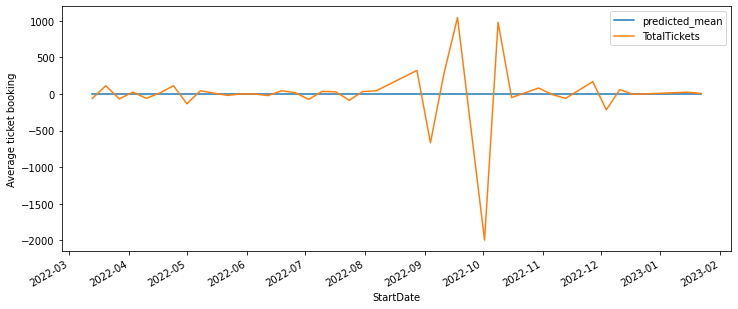

In [46]:
#Making Predictions with the trained Arima model
start = len(train)
end = len(train)+len(test)-1
pred = tickets_arima.predict(start=start, end=end, typ='levels')
pred.index=tickets_arima_df.index[start:end+1] #reseting index after prediction
# print('Predictions')
# print(pred)
# print('Test data')
# print(test['TotalTickets'])
pred.plot(legend=True, figsize=(20,10), xlabel = 'Week', ylabel='Average ticket booking' )
test['TotalTickets'].plot(legend=True, figsize=(12,5))


In [47]:
# #Calculating mean squared error for ARIMA
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# print('Mean Average Error: ', mean_absolute_error(test, pred))
# print('Mean Squared Error: ', mean_squared_error(test, pred))
# print('Root Mean Squared Error: ', mean_squared_error(test, pred, squared=False))

# XGBoost Prediction - Total Ticket bookings

In [48]:
# print(result_df)
result_df.columns
# result_df.set_index('EventDate')

Index(['StartDate', 'Season', 'SeasonCode', 'EventId', 'TotalTickets',
       'LastbookingWeek', 'FirstbookingWeek', 'TotalWeeksToSell', 'EventDate',
       'eventdayofweek', 'eventquarter', 'eventmonth', 'eventyear',
       'eventdayofyear', 'eventdayofmonth', 'eventweekofyear'],
      dtype='object')

In [49]:
from xgboost import XGBRegressor

train1, test1 = train_test_split(result_df, shuffle=False, test_size=0.1)
X_train = train1.drop(labels=['TotalTickets', 'StartDate', 'Season', 'EventDate', 'EventId'  ], axis=1).reset_index()
y_train = train1['TotalTickets'].values 

X_test = test1.drop(labels=['TotalTickets', 'StartDate',  'Season', 'EventDate', 'EventId'  ], axis=1).reset_index()
y_test = test1['TotalTickets'].values 

In [50]:
reg = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg.fit(X_train, 
        y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='mae')

[0]	validation_0-mae:174.34356	validation_1-mae:58.20209
[1]	validation_0-mae:172.73703	validation_1-mae:57.46144
[2]	validation_0-mae:171.21275	validation_1-mae:56.78295
[3]	validation_0-mae:169.76891	validation_1-mae:56.11054
[4]	validation_0-mae:168.41220	validation_1-mae:55.48228
[5]	validation_0-mae:167.13070	validation_1-mae:54.91158
[6]	validation_0-mae:165.92985	validation_1-mae:54.39189
[7]	validation_0-mae:164.77351	validation_1-mae:53.88712
[8]	validation_0-mae:163.68380	validation_1-mae:53.39917
[9]	validation_0-mae:162.63366	validation_1-mae:52.98713


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[10]	validation_0-mae:161.64268	validation_1-mae:52.59731
[11]	validation_0-mae:160.68903	validation_1-mae:52.18318
[12]	validation_0-mae:159.68715	validation_1-mae:51.80722
[13]	validation_0-mae:158.79166	validation_1-mae:51.42662
[14]	validation_0-mae:157.88054	validation_1-mae:51.06069
[15]	validation_0-mae:157.07342	validation_1-mae:50.72369
[16]	validation_0-mae:156.24411	validation_1-mae:50.39913
[17]	validation_0-mae:155.47117	validation_1-mae:50.10042
[18]	validation_0-mae:154.77396	validation_1-mae:49.79363
[19]	validation_0-mae:154.06183	validation_1-mae:49.50195
[20]	validation_0-mae:153.38811	validation_1-mae:49.22782
[21]	validation_0-mae:152.73920	validation_1-mae:48.95085
[22]	validation_0-mae:152.10822	validation_1-mae:48.70133
[23]	validation_0-mae:151.51903	validation_1-mae:48.43754
[24]	validation_0-mae:150.95488	validation_1-mae:48.21696
[25]	validation_0-mae:150.40109	validation_1-mae:47.97753
[26]	validation_0-mae:149.86813	validation_1-mae:47.77889
[27]	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

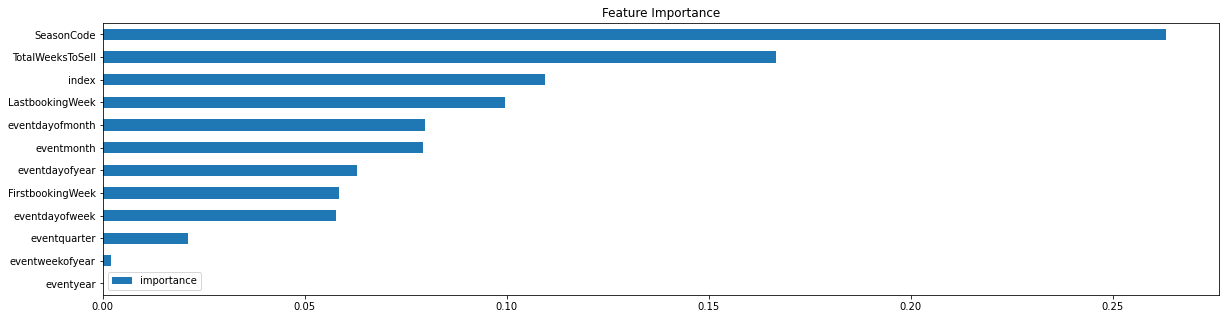

In [51]:
fi = pd.DataFrame(data=reg.feature_importances_, index= reg.get_booster().feature_names,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [52]:
predictions = reg.predict(X_test)

In [ ]:
# reg.save_model("/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalTickets.json")
# xbg_reg = XGBRegressor()
# xbg_reg.load_model("/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalTickets.json")

# predings = xbg_reg.predict(X_test)
# print(predings)

In [62]:
print(X_test)
# data_table.DataTable(X_test)

     index  SeasonCode  LastbookingWeek  FirstbookingWeek  TotalWeeksToSell  \
0     1703           2              1.0              22.0              21.0   
1     1704           2              3.0              32.0              29.0   
2     1705           2              0.0              64.0              64.0   
3     1706           2              4.0              30.0              26.0   
4     1707           2              0.0              29.0              29.0   
..     ...         ...              ...               ...               ...   
185   1888           0              0.0              59.0              59.0   
186   1889           0             22.0              25.0               3.0   
187   1890           0              0.0              27.0              27.0   
188   1891           3             42.0              42.0               0.0   
189   1892           3              0.0              37.0              37.0   

     eventdayofweek  eventquarter  eventmonth  even

In [53]:
# print(predictions)
test = test1.reset_index().drop('index', axis=1)
test['XGBoostTotalTickets'] = pd.Series(predictions)

In [54]:
print(test)

              StartDate  Season  SeasonCode  EventId  TotalTickets  \
0   2022-07-28 17:00:00  Summer           2    25885            20   
1   2022-07-29 13:00:00  Summer           2    25289            22   
2   2022-08-02 14:00:00  Summer           2    24776            13   
3   2022-08-02 15:00:00  Summer           2    25377            27   
4   2022-08-02 16:00:00  Summer           2    25360            26   
..                  ...     ...         ...      ...           ...   
185 2022-12-05 17:45:00  Autumn           0    24692            46   
186 2022-12-07 15:00:00  Autumn           0    26281             7   
187 2022-12-15 15:00:00  Autumn           0    27225             4   
188 2023-01-13 10:00:00  Winter           3    27545             1   
189 2023-01-17 14:30:00  Winter           3    27368             6   

     LastbookingWeek  FirstbookingWeek  TotalWeeksToSell   EventDate  \
0                1.0              22.0              21.0  2022-07-28   
1              

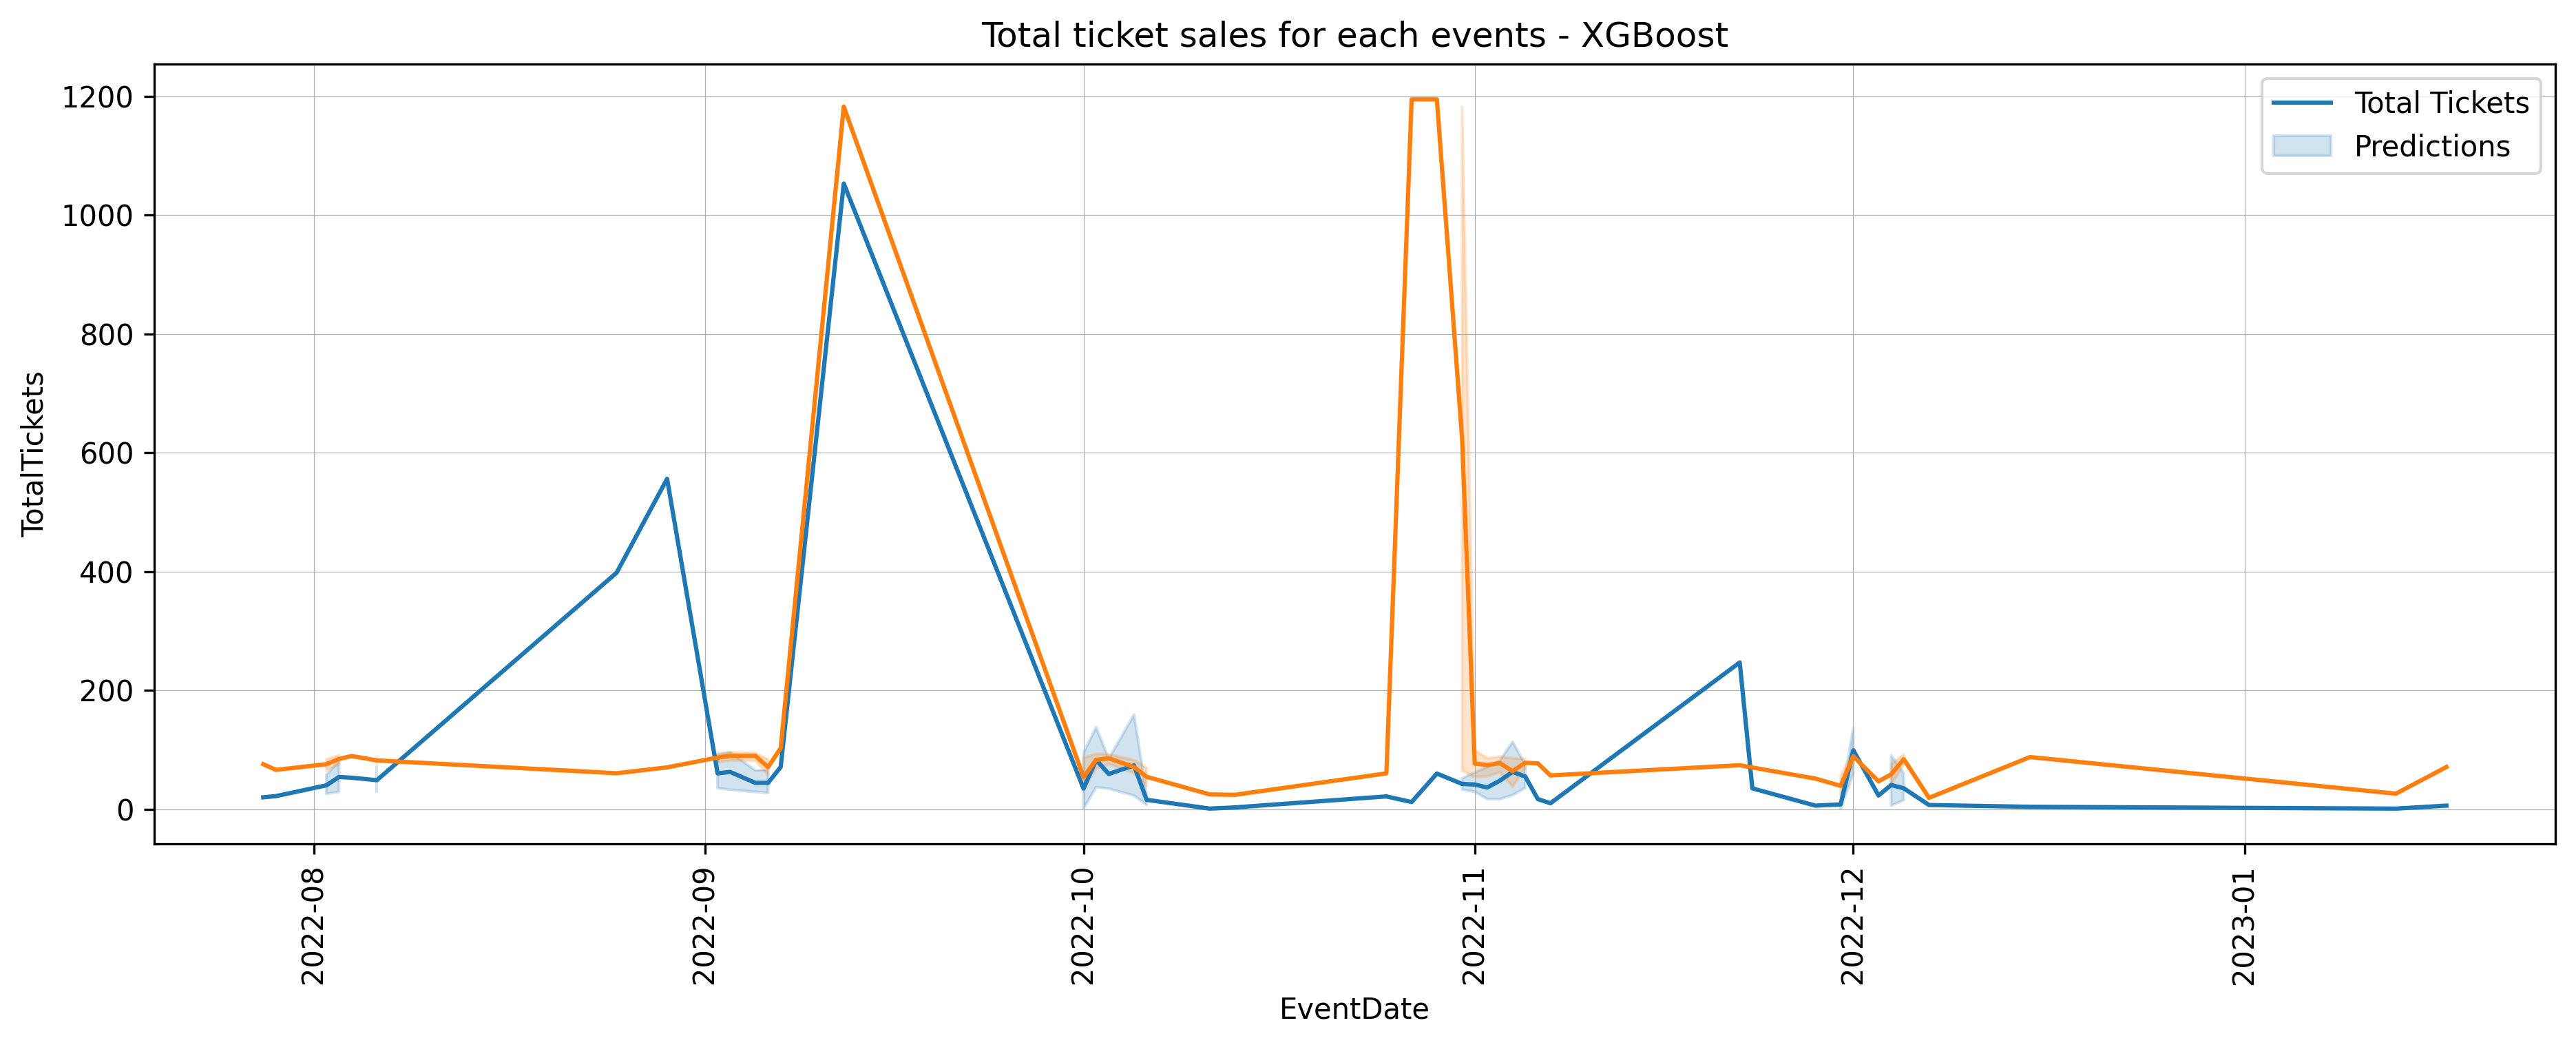

In [55]:
plt.rcParams.update({'figure.figsize': (15, 5), 'figure.dpi':300})
fig, ax = plt.subplots()

# sns.lineplot(data=test['TotalTickets'])
# sns.lineplot(data=test['predictions'])
sns.lineplot(x=test['EventDate'], y =test['TotalTickets'], data=test)
sns.lineplot(x=test['EventDate'], y =test['XGBoostTotalTickets'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Total Tickets","Predictions"])
plt.title('Total ticket sales for each events - XGBoost')
ax.tick_params(axis='x', rotation=90)

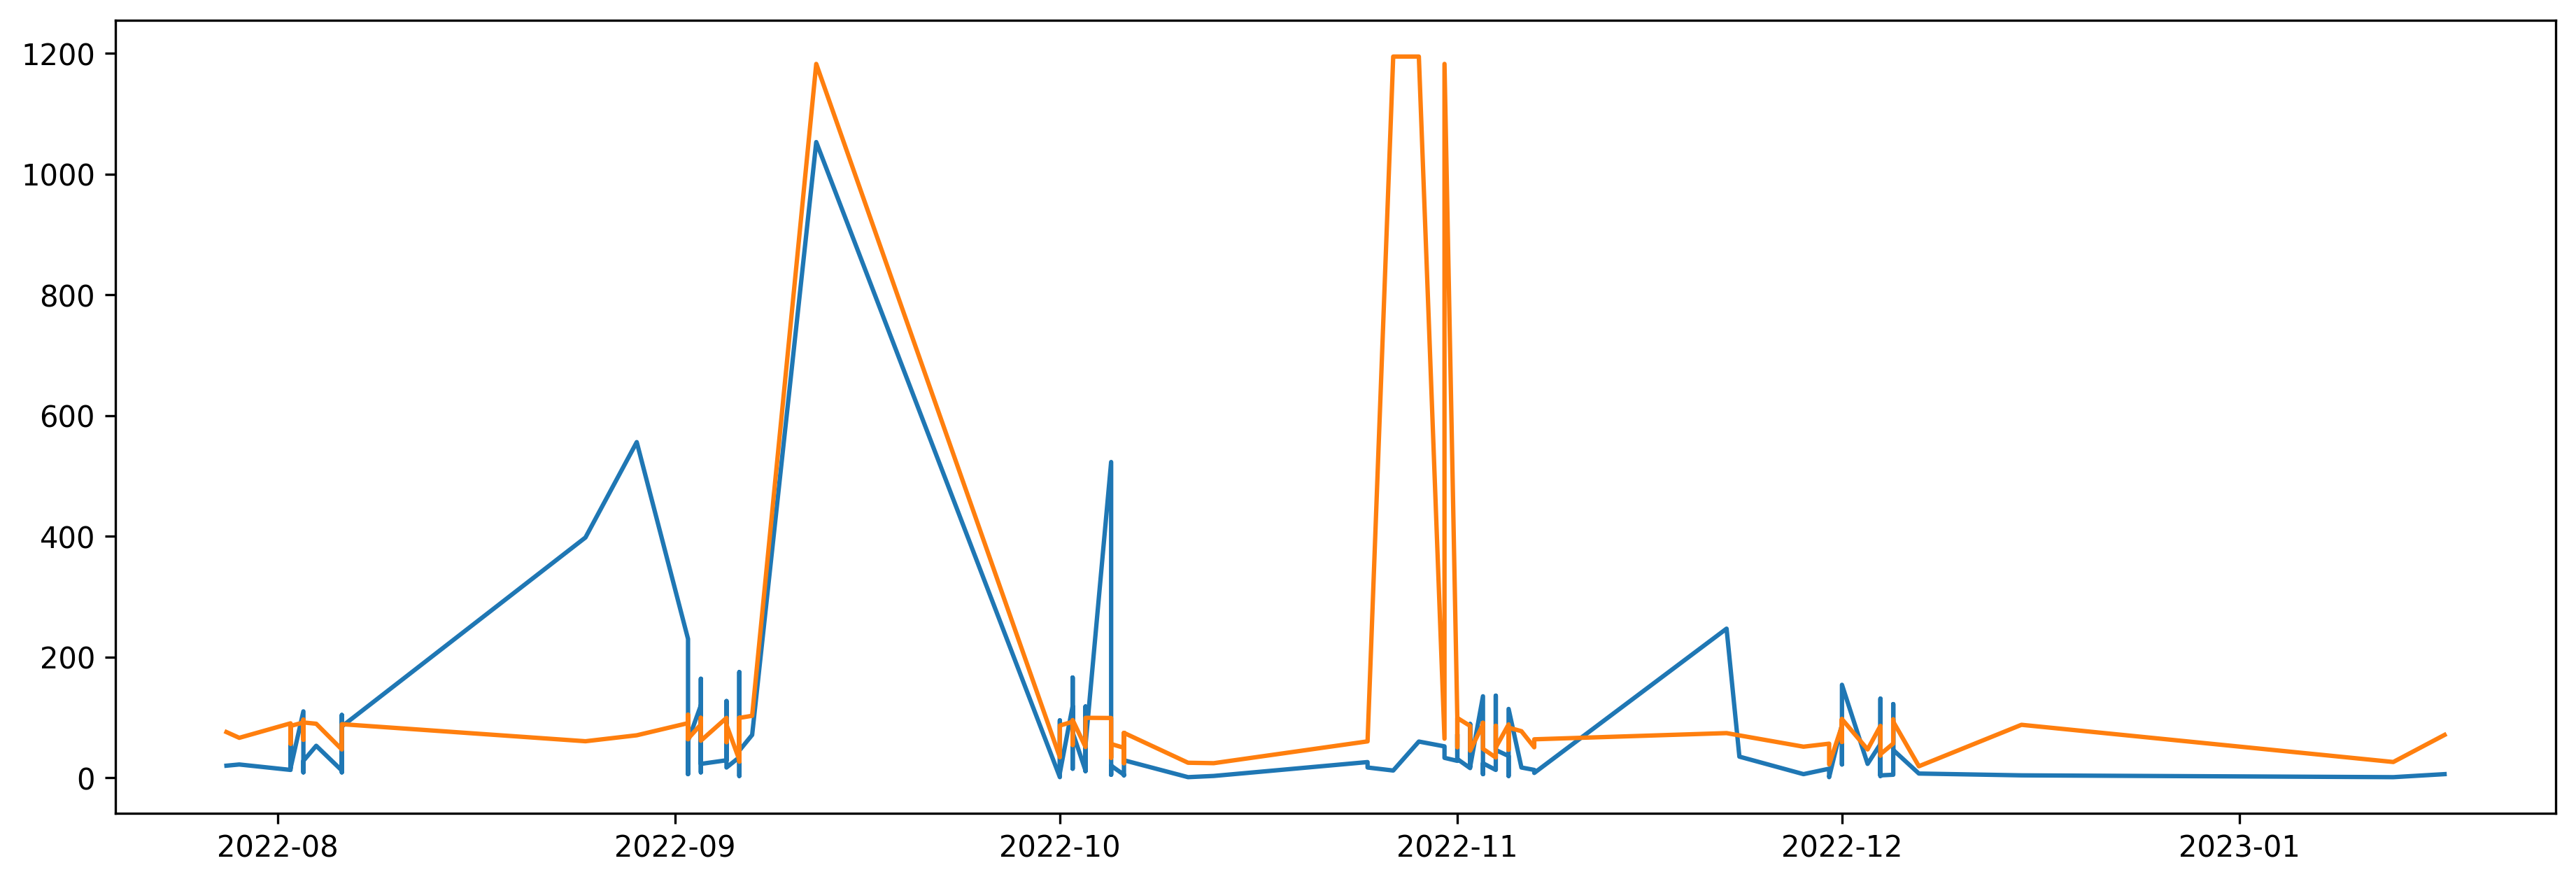

In [56]:
plt.plot(test['EventDate'], test['TotalTickets'] )
plt.plot(test['EventDate'], test['XGBoostTotalTickets'] )

In [57]:
print('Mean Average Error: ', mean_absolute_error(test['TotalTickets'], test['XGBoostTotalTickets']))
print('Mean Squared Error: ', mean_squared_error(test['TotalTickets'], test['XGBoostTotalTickets']))
print('Root Mean Squared Error: ', mean_squared_error(test['TotalTickets'], test['XGBoostTotalTickets'], squared=False))

Mean Average Error:  66.75817866074412
Mean Squared Error:  26393.856484091182
Root Mean Squared Error:  162.46186162940268


In [58]:
# reg.save_model('/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalTickets.bst')

reg.save_model("/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalTickets.json")

# XGBoost Prediction - Total Weeks to Sell

In [86]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

train2, test2 = train_test_split(result_df, shuffle=False, test_size=0.1)

X_train2 = train2.drop(labels=['TotalWeeksToSell', 'StartDate', 'Season', 'EventDate', 'EventId', 'TotalTickets', 'LastbookingWeek', 'FirstbookingWeek'], axis=1)
y_train2 = train2['TotalWeeksToSell'].values 

X_test2 = test2.drop(labels=['TotalWeeksToSell', 'StartDate', 'Season', 'EventDate', 'EventId', 'TotalTickets' , 'LastbookingWeek', 'FirstbookingWeek'], axis=1)
y_test2 = test2['TotalWeeksToSell'].values 

In [ ]:
data_table.DataTable(train2)

In [ ]:
reg2 = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg2.fit(X_train2, 
        y_train2,
        eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        eval_metric='mae')

In [66]:
# fi2 = pd.DataFrame(data=reg.feature_importances_, index= reg2.get_booster().feature_names,
#              columns=['importance'])
# fi2.sort_values('importance').plot(kind='barh', title='Feature Importance')
# plt.show()

In [88]:
weekpredictions = reg2.predict(X_test2)
test = test.reset_index().drop('index', axis=1)
test['XGBoostTotalWeeksToSell'] = pd.Series(weekpredictions)


In [ ]:
# reg2.save_model('/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalweeks.bst')
reg2.save_model('/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalweeks.json')

xbg_reg = XGBRegressor()
xbg_reg.load_model("/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostTotalweeks.json")

predings2 = xbg_reg.predict(X_test2)
print(predings2)

In [91]:
test = test.reset_index().drop('index', axis=1)
test['XGBoostTotalWeeksToSell2'] = pd.Series(predings2)

In [ ]:
# print(test)
data_table.DataTable(test)

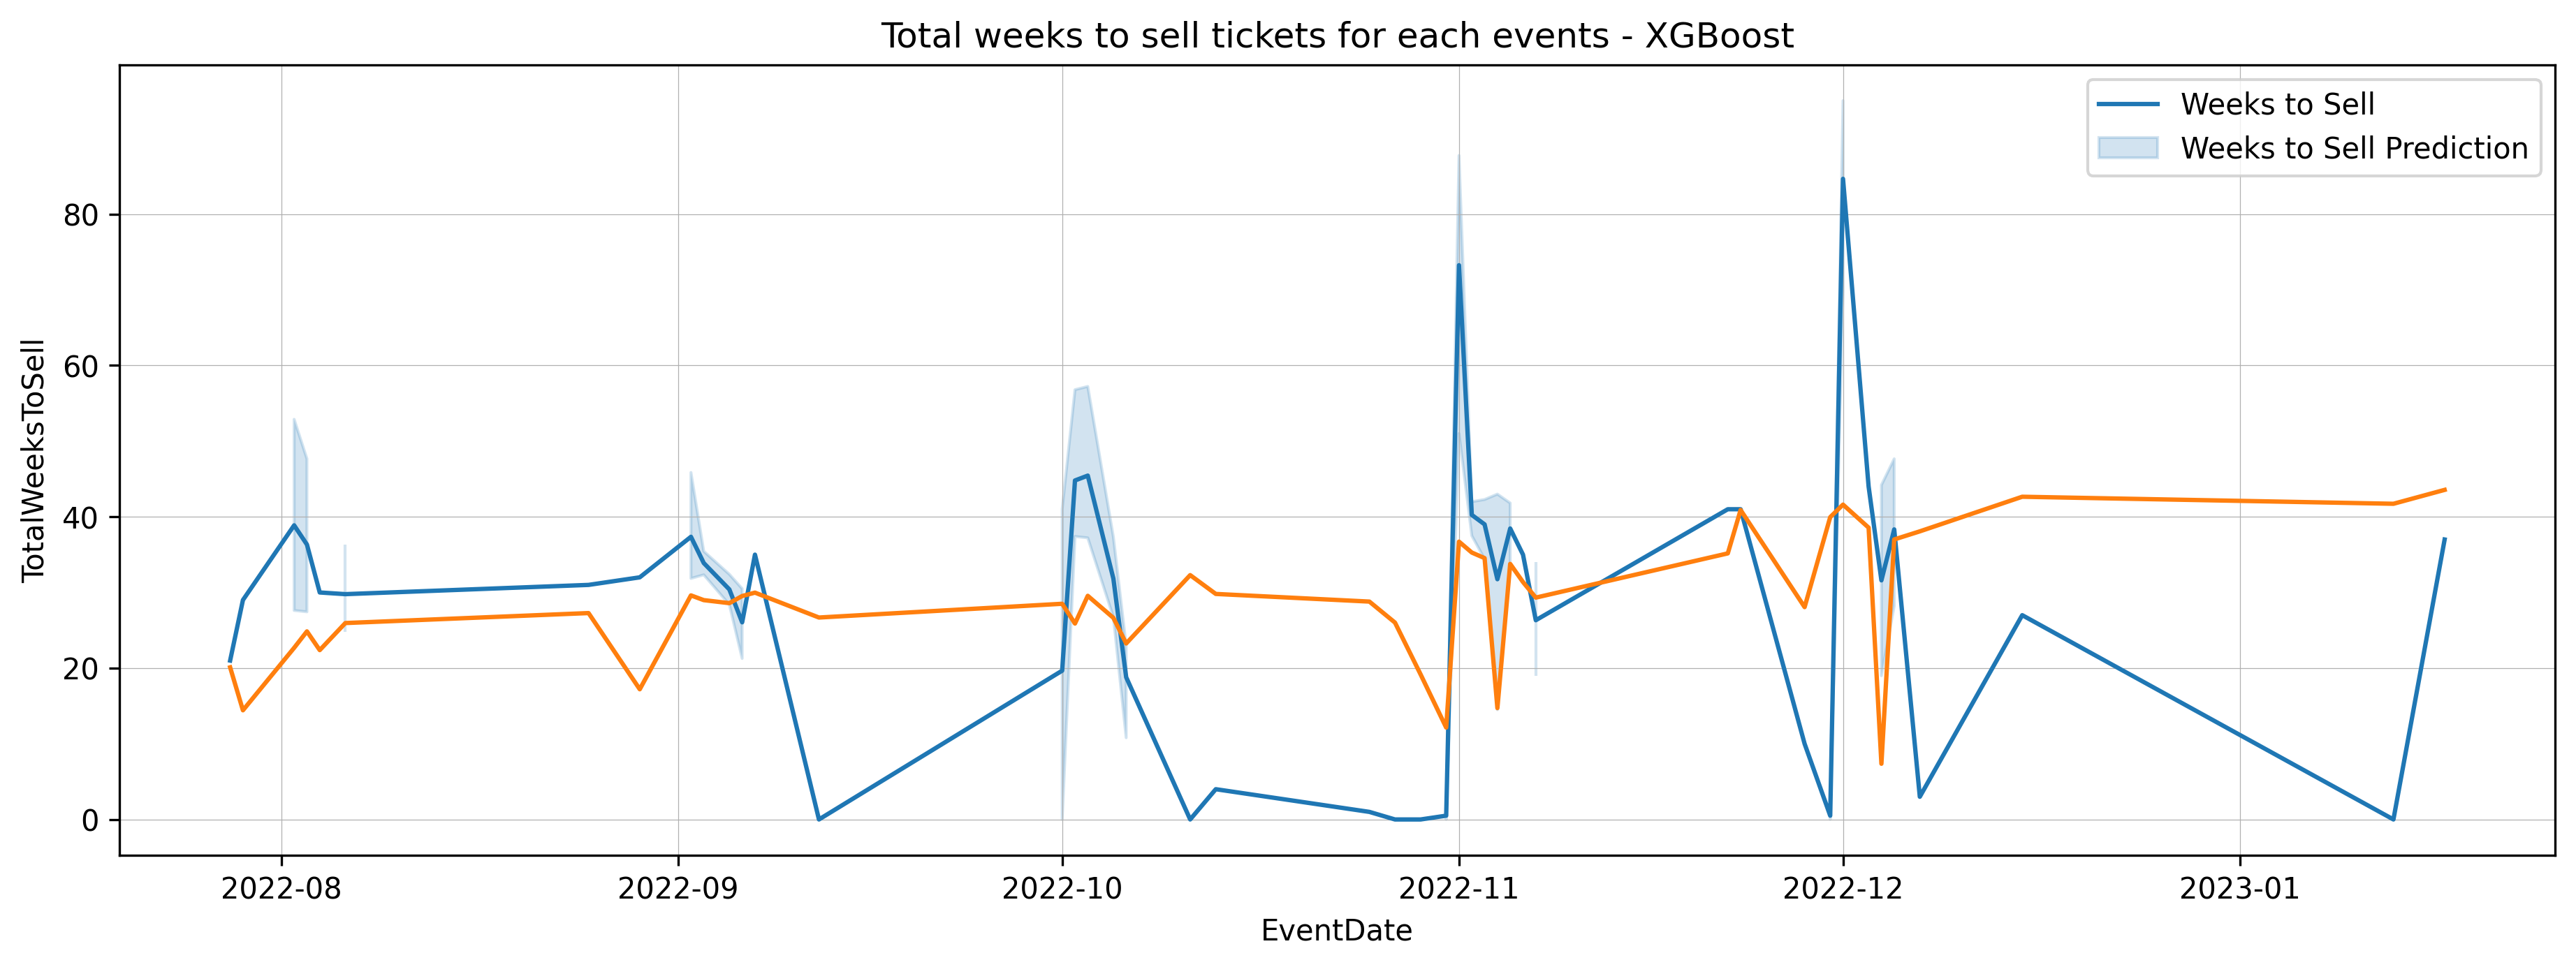

In [92]:
sns.lineplot(x=test['EventDate'], y =test['TotalWeeksToSell'], data=test)
sns.lineplot(x=test['EventDate'], y =test['XGBoostTotalWeeksToSell'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weeks to Sell","Weeks to Sell Prediction"])
plt.title('Total weeks to sell tickets for each events - XGBoost')
ax.tick_params(axis='x', rotation=90)

In [70]:
#Neural Network Error
print('Mean Average Error: ', mean_absolute_error(test['TotalWeeksToSell'], test['XGBoostTotalWeeksToSell']))
print('Mean Squared Error: ', mean_squared_error(test['TotalWeeksToSell'], test['XGBoostTotalWeeksToSell']))
print('Root Mean Squared Error: ', mean_squared_error(test['TotalWeeksToSell'], test['XGBoostTotalWeeksToSell'], squared=False))

Mean Average Error:  2.0006377483080877
Mean Squared Error:  50.500605477448374
Root Mean Squared Error:  7.106377802892862


# Neural Network Prediction - Total Ticket bookings

In [95]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() 
model.add(Dense(units=128, activation='relu'))  
model.add(Dense(units=64, activation='relu')) 
model.add(Dense(units=32, activation='relu')) 
model.add(Dense(units=1))  
model.compile('adam', loss='mse')  

history = model.fit(X_train, y_train , epochs=200) 
predictions2 = model.predict(X_test)  

model.save_model('/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/NNTotalTickets.bst'))
# print(predictions2)

Epoch 1/200
54/54 [==============================] - 1s 2ms/step - loss: 279355.1875
Epoch 2/200
54/54 [==============================] - 0s 2ms/step - loss: 268602.4688
Epoch 3/200
54/54 [==============================] - 0s 2ms/step - loss: 264955.5312
Epoch 4/200
54/54 [==============================] - 0s 2ms/step - loss: 266113.0000
Epoch 5/200
54/54 [==============================] - 0s 2ms/step - loss: 265034.6875
Epoch 6/200
54/54 [==============================] - 0s 2ms/step - loss: 261790.3750
Epoch 7/200
54/54 [==============================] - 0s 2ms/step - loss: 263629.6875
Epoch 8/200
54/54 [==============================] - 0s 2ms/step - loss: 263305.7188
Epoch 9/200
54/54 [==============================] - 0s 2ms/step - loss: 263026.7812
Epoch 10/200
54/54 [==============================] - 0s 2ms/step - loss: 262917.1562
Epoch 11/200
54/54 [==============================] - 0s 2ms/step - loss: 260392.4219
Epoch 12/200
54/54 [==============================] - 0s 2ms/st

In [96]:
test = test.reset_index().drop('index', axis=1)
test['NNTotalTickets'] = pd.Series(predictions2.flatten())
print(test)

              StartDate  Season  SeasonCode  EventId  TotalTickets  \
0   2022-08-02 15:00:00  Summer           2    25377            27   
1   2022-08-02 16:00:00  Summer           2    25360            26   
2   2022-08-02 16:00:00  Summer           2    25739            83   
3   2022-08-02 17:30:00  Summer           2    25202            53   
4   2022-08-02 17:30:00  Summer           2    25570            38   
..                  ...     ...         ...      ...           ...   
185 2022-12-07 15:00:00  Autumn           0    26281             7   
186 2022-12-15 15:00:00  Autumn           0    27225            13   
187 2023-01-13 10:00:00  Winter           3    27545             1   
188 2023-01-17 14:30:00  Winter           3    27368             6   
189 2023-03-01 00:00:00  Winter           3    27560             2   

     LastbookingWeek  FirstbookingWeek  TotalWeeksToSell   EventDate  \
0                4.0              30.0              26.0  2022-08-02   
1              

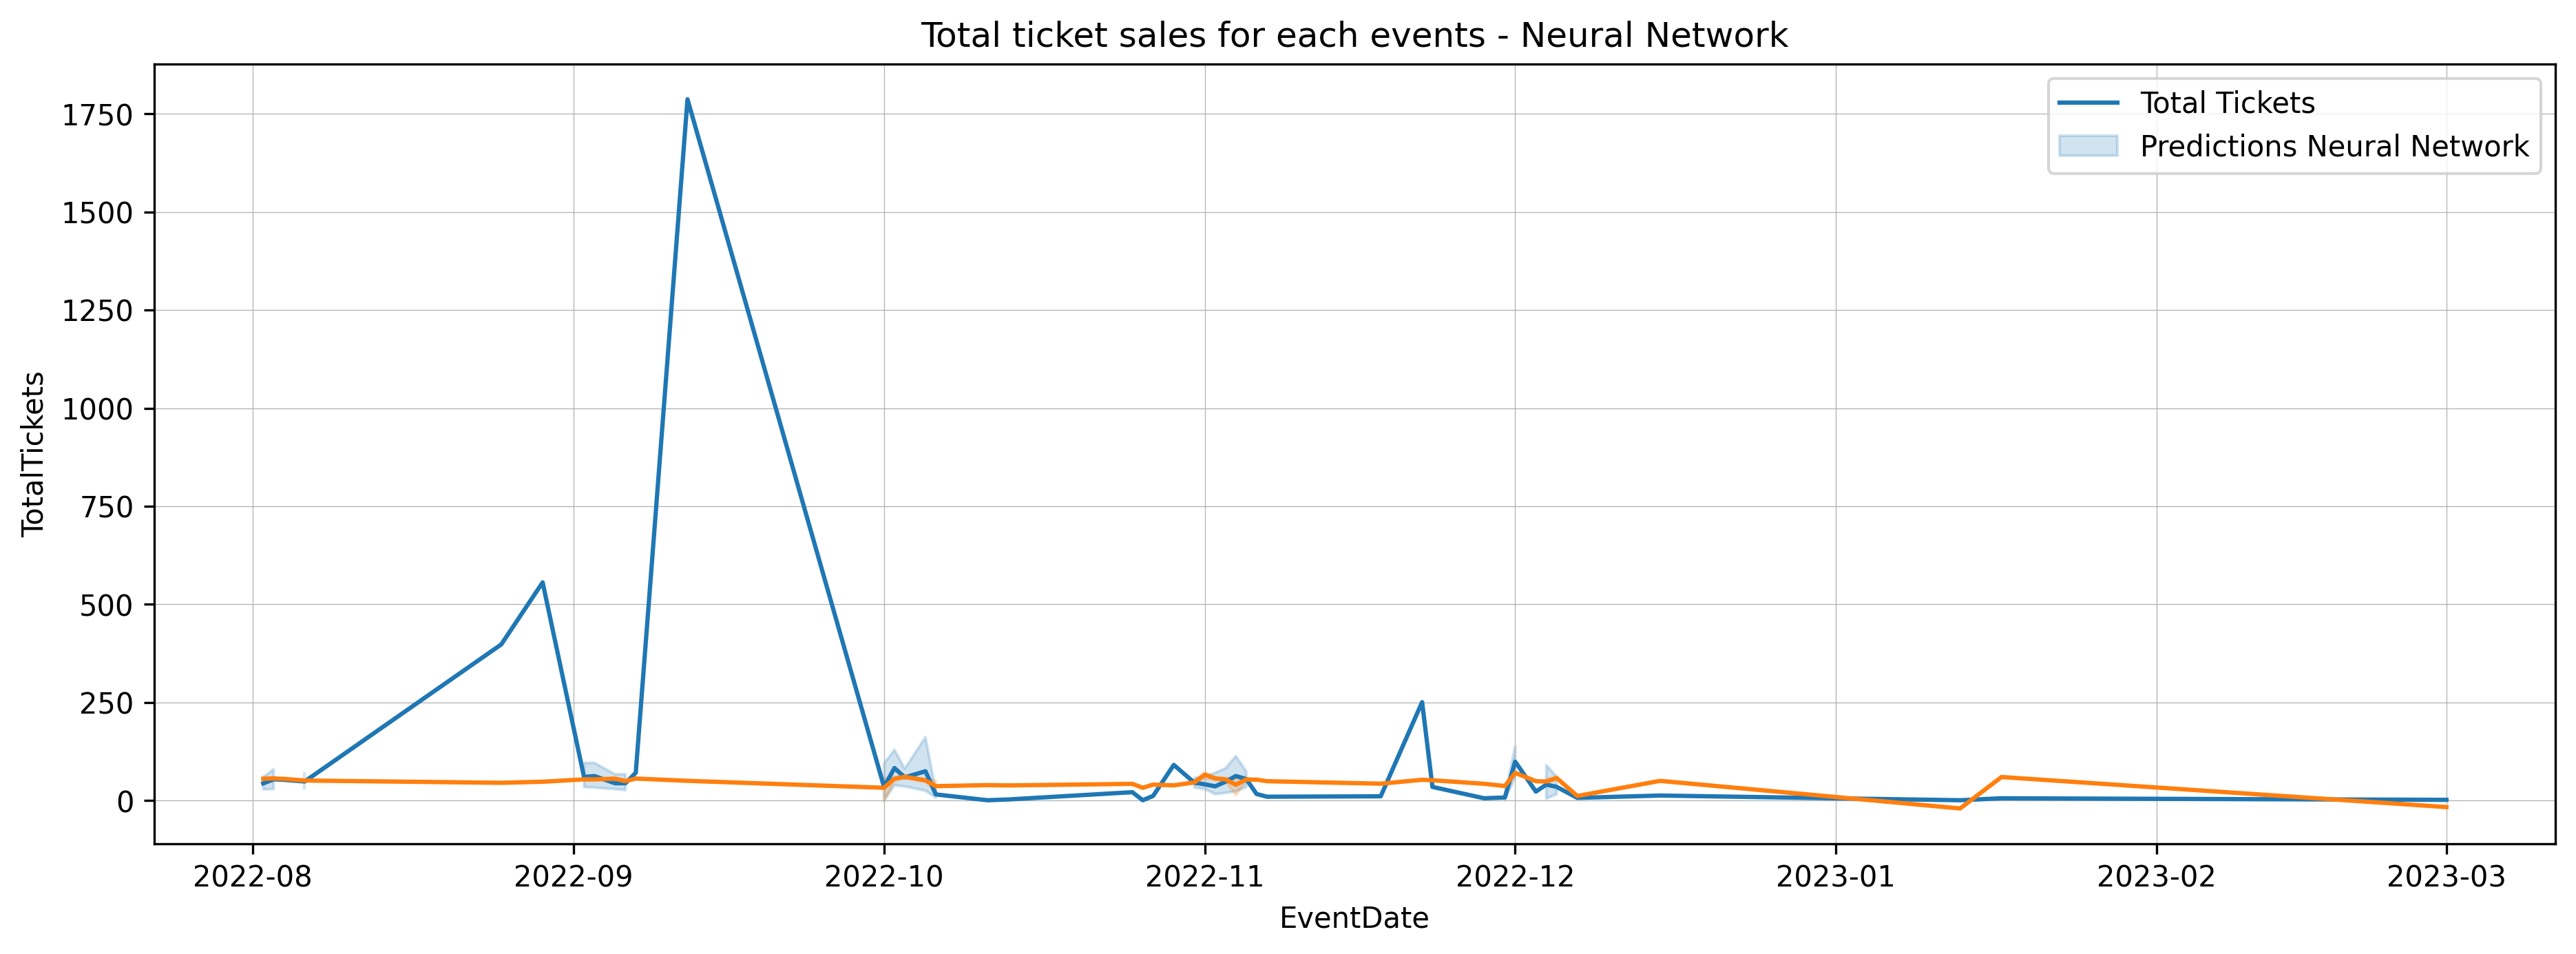

In [97]:
sns.lineplot(x=test['EventDate'], y =test['TotalTickets'], data=test)
sns.lineplot(x=test['EventDate'], y =test['NNTotalTickets'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Total Tickets","Predictions Neural Network"])
plt.title('Total ticket sales for each events - Neural Network')
ax.tick_params(axis='x', rotation=90)

In [98]:
#Neural Network Error
print('Mean Average Error: ', mean_absolute_error(test['TotalTickets'], test['NNTotalTickets']))
print('Mean Squared Error: ', mean_squared_error(test['TotalTickets'], test['NNTotalTickets']))
print('Root Mean Squared Error: ', mean_squared_error(test['TotalTickets'], test['NNTotalTickets'], squared=False))

Mean Average Error:  48.1964408523158
Mean Squared Error:  20790.186770391818
Root Mean Squared Error:  144.18802575245914


# Neural Network Prediction - Total weeks to sell ticket

In [99]:
from keras.models import Sequential
from keras.layers import Dense

model2 = Sequential() 
model2.add(Dense(units=128, activation='relu'))  
model2.add(Dense(units=64, activation='relu')) 
model2.add(Dense(units=32, activation='relu')) 
model2.add(Dense(units=1))  
model2.compile('adam', loss='mse')  

history2 = model2.fit(X_train2, y_train2 , epochs=200) 
NNweekpredictions = model2.predict(X_test2)  

# print(NNweekpredictions)

Epoch 1/200
54/54 [==============================] - 1s 2ms/step - loss: 353.3507
Epoch 2/200
54/54 [==============================] - 0s 2ms/step - loss: 160.8426
Epoch 3/200
54/54 [==============================] - 0s 2ms/step - loss: 150.4798
Epoch 4/200
54/54 [==============================] - 0s 2ms/step - loss: 120.4774
Epoch 5/200
54/54 [==============================] - 0s 2ms/step - loss: 85.9143
Epoch 6/200
54/54 [==============================] - 0s 3ms/step - loss: 90.3335
Epoch 7/200
54/54 [==============================] - 0s 3ms/step - loss: 35.2736
Epoch 8/200
54/54 [==============================] - 0s 3ms/step - loss: 25.0459
Epoch 9/200
54/54 [==============================] - 0s 3ms/step - loss: 13.6642
Epoch 10/200
54/54 [==============================] - 0s 3ms/step - loss: 6.3796
Epoch 11/200
54/54 [==============================] - 0s 4ms/step - loss: 6.8709
Epoch 12/200
54/54 [==============================] - 0s 3ms/step - loss: 6.2085
Epoch 13/200
54/54 [====

In [100]:
test = test.reset_index().drop('index', axis=1)
test['NNTotalWeeksToSell'] = pd.Series(NNweekpredictions.flatten())
data_table.DataTable(test)

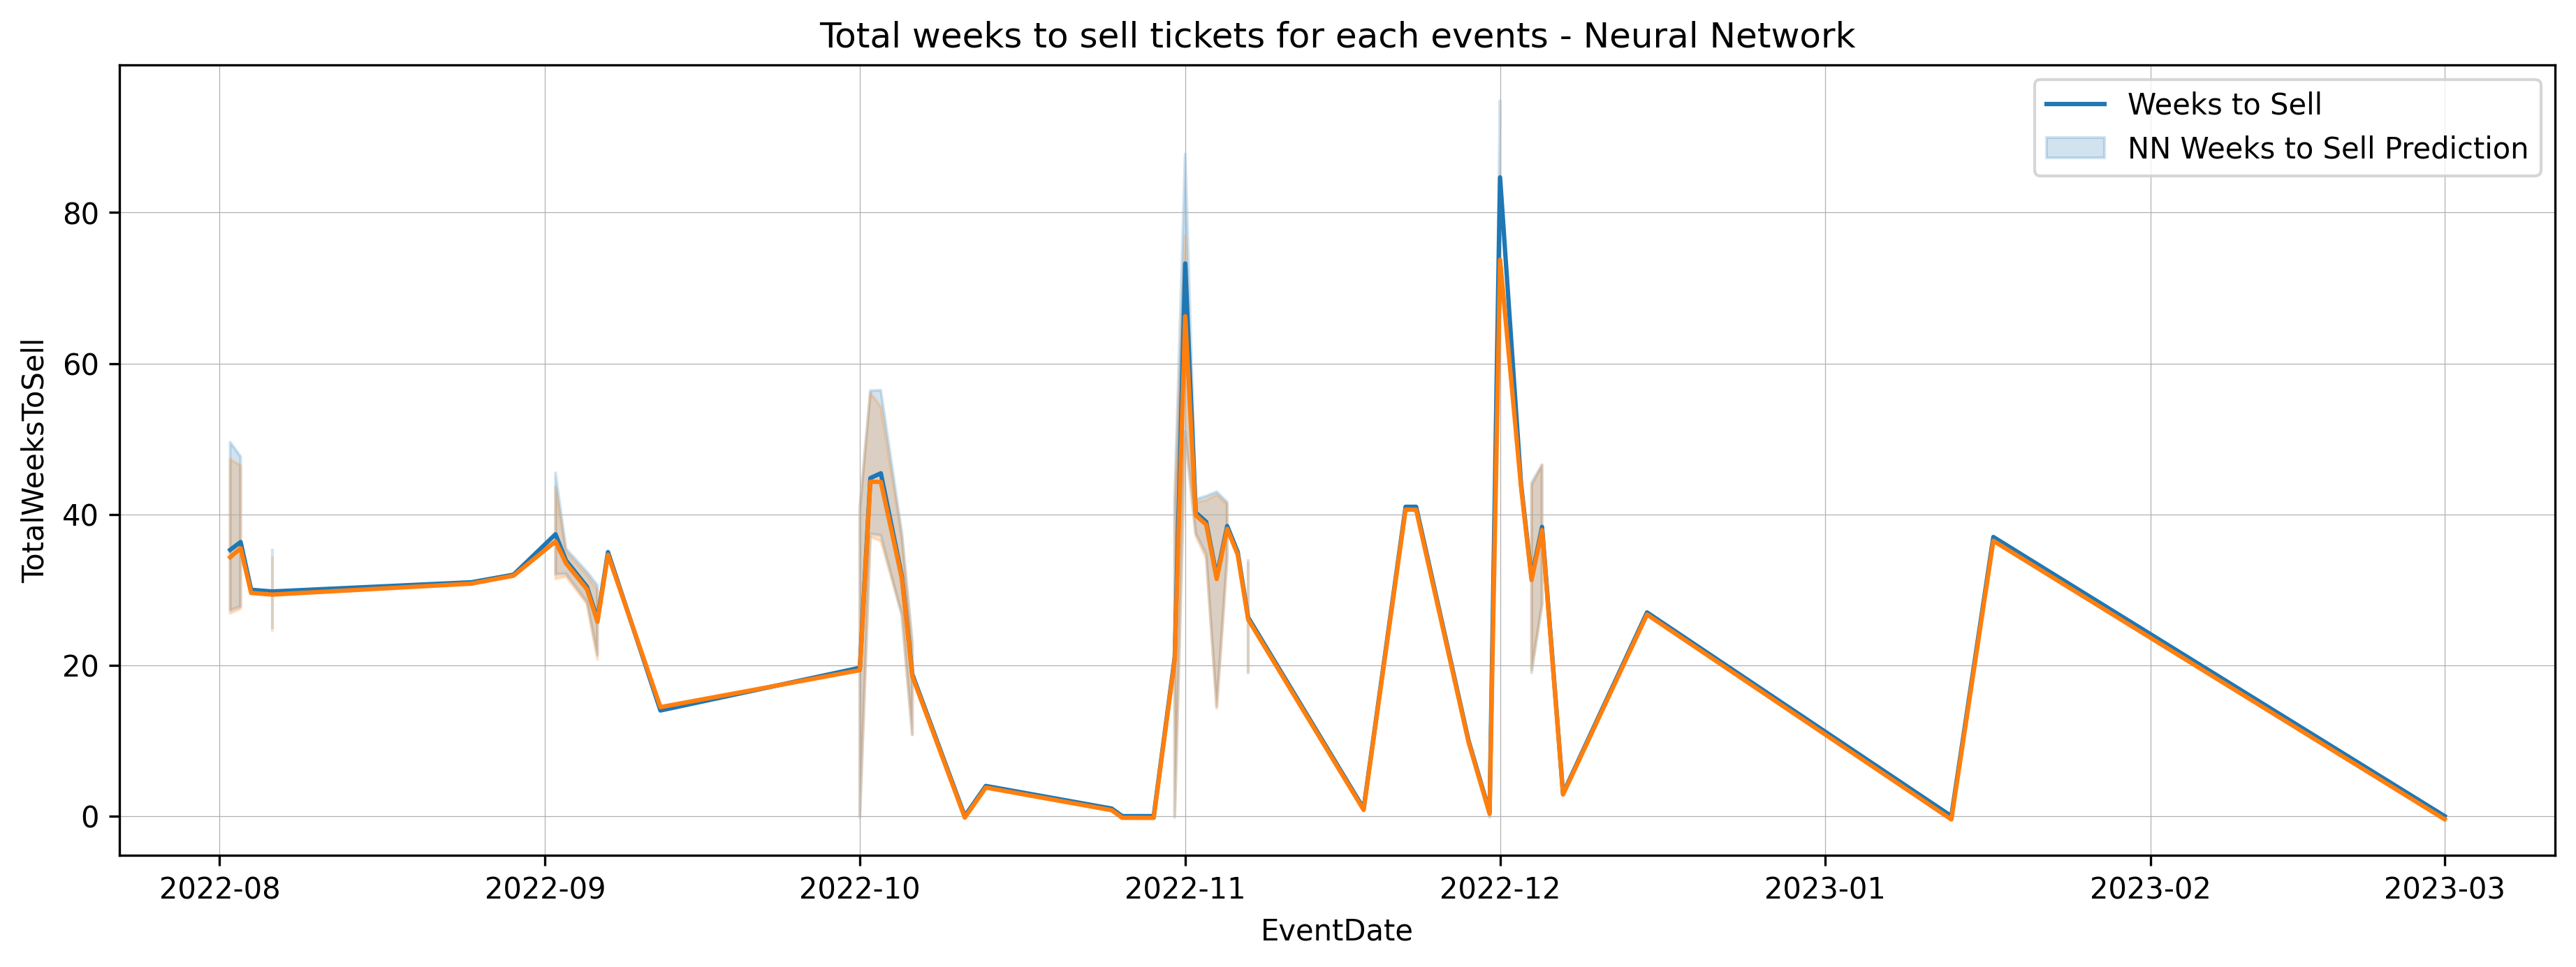

In [101]:
sns.lineplot(x=test['EventDate'], y =test['TotalWeeksToSell'], data=test)
sns.lineplot(x=test['EventDate'], y =test['NNTotalWeeksToSell'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weeks to Sell","NN Weeks to Sell Prediction"])
plt.title('Total weeks to sell tickets for each events - Neural Network')
ax.tick_params(axis='x', rotation=90)

In [102]:
data_table.DataTable(test)

# Weekly booking Predictions - XGBoost and NN

In [103]:
# weeklyPred = Company_df2.set_index('StatusCreatedDate')
# weeklyPred = weeklyPred.resample('w').sum()

# weeklyPred = weeklyPred.groupby('bookingWeeksToEvent').mean()
weeklyPred = Company_df2[['StatusCreatedDate', 'SeasonCode', 'bookingWeeksToEvent', 'GroupSize']]
weeklyPred = booking_features(weeklyPred)
weeklyPred = Company_df2.groupby(['SeasonCode', 'bookingWeeksToEvent', 'bookingquarter', 'bookingweekofyear', 'bookingmonth', 'bookingyear']).aggregate({'GroupSize':'sum'}).reset_index()
# weeklyPred.set_index('StatusCreatedDate')
# weeklyPred = weeklyPred.groupby('SeasonCode').mean()
data_table.DataTable(weeklyPred)

Output hidden; open in https://colab.research.google.com to view.

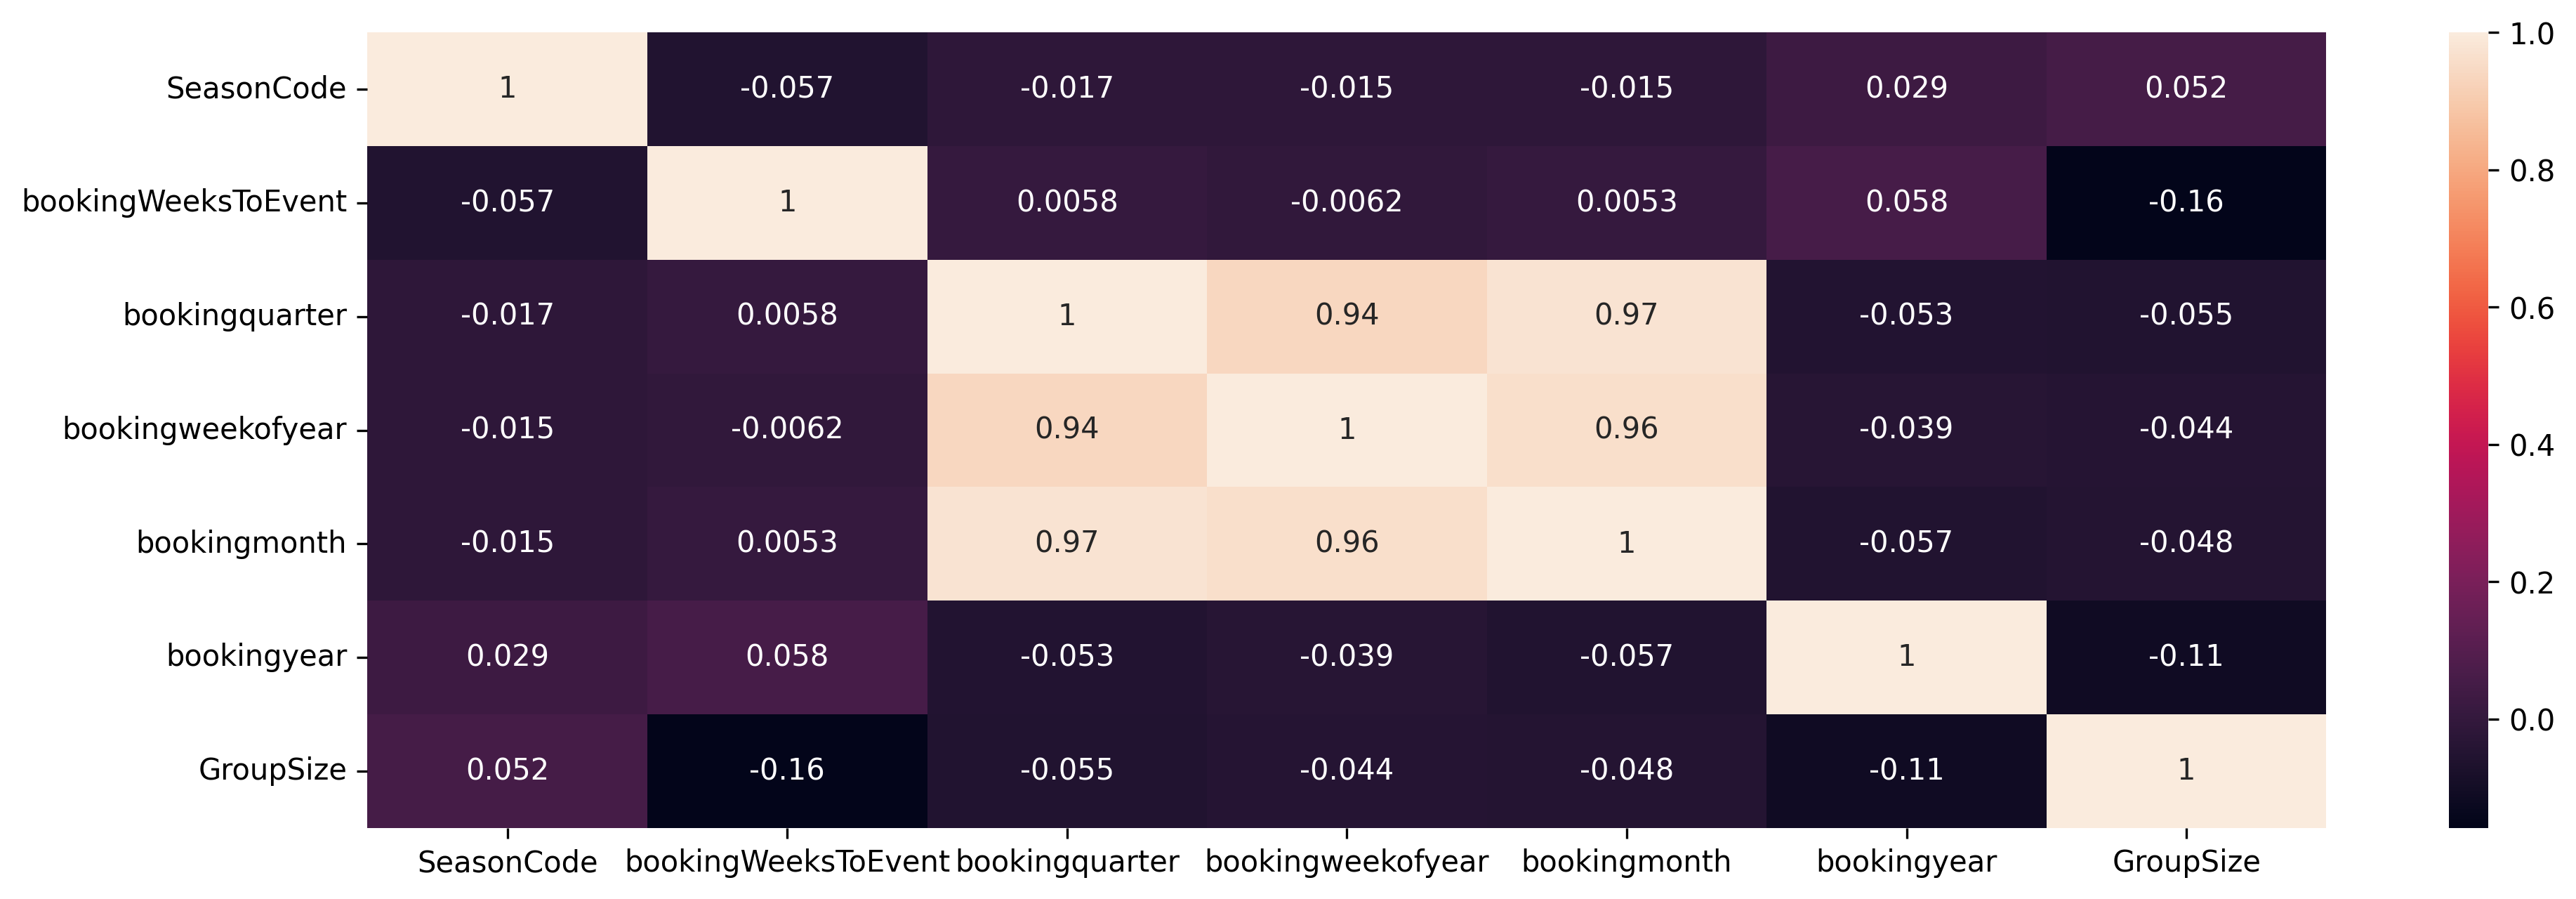

In [104]:
sns.heatmap(weeklyPred.corr(), annot = True)
plt.show()

In [105]:
train3, test3 = train_test_split(weeklyPred, shuffle=False, test_size=0.1)

X_train3 = train3.drop(labels=['GroupSize' ], axis=1)
y_train3 = train3['GroupSize'].values 

X_test3 = test3.drop(labels=['GroupSize'], axis=1)
y_test3 = test3['GroupSize'].values 

XGBoost for weekly booking

In [106]:
reg3 = XGBRegressor(n_estimators=500, learning_rate=0.01)
reg3.fit(X_train3, 
        y_train3,
        eval_set=[(X_train3, y_train3), (X_test3, y_test3)],
        eval_metric='mae')

[0]	validation_0-mae:69.95534	validation_1-mae:47.41129
[1]	validation_0-mae:69.36243	validation_1-mae:47.08119
[2]	validation_0-mae:68.80669	validation_1-mae:46.84123
[3]	validation_0-mae:68.29758	validation_1-mae:46.62980
[4]	validation_0-mae:67.81068	validation_1-mae:46.46996
[5]	validation_0-mae:67.35790	validation_1-mae:46.32864
[6]	validation_0-mae:66.91997	validation_1-mae:46.22197
[7]	validation_0-mae:66.50325	validation_1-mae:46.12253
[8]	validation_0-mae:66.11223	validation_1-mae:46.03627
[9]	validation_0-mae:65.73518	validation_1-mae:45.95090
[10]	validation_0-mae:65.37644	validation_1-mae:45.88363
[11]	validation_0-mae:65.03576	validation_1-mae:45.84838
[12]	validation_0-mae:64.70942	validation_1-mae:45.84429
[13]	validation_0-mae:64.39754	validation_1-mae:45.85442


/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-mae:64.10297	validation_1-mae:45.88303
[15]	validation_0-mae:63.81688	validation_1-mae:45.92174
[16]	validation_0-mae:63.54030	validation_1-mae:45.96090
[17]	validation_0-mae:63.27582	validation_1-mae:46.00472
[18]	validation_0-mae:63.01859	validation_1-mae:46.06536
[19]	validation_0-mae:62.77479	validation_1-mae:46.11266
[20]	validation_0-mae:62.53067	validation_1-mae:46.17436
[21]	validation_0-mae:62.30641	validation_1-mae:46.23289
[22]	validation_0-mae:62.09562	validation_1-mae:46.30449
[23]	validation_0-mae:61.88091	validation_1-mae:46.36539
[24]	validation_0-mae:61.68431	validation_1-mae:46.43355
[25]	validation_0-mae:61.49743	validation_1-mae:46.50581
[26]	validation_0-mae:61.30615	validation_1-mae:46.57331
[27]	validation_0-mae:61.13197	validation_1-mae:46.63984
[28]	validation_0-mae:60.95710	validation_1-mae:46.71859
[29]	validation_0-mae:60.79572	validation_1-mae:46.79050
[30]	validation_0-mae:60.64189	validation_1-mae:46.86444
[31]	validation_0-mae:60.48410	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [133]:
weeklybookingpredictions = reg3.predict(X_test3)
test3 = test3.reset_index().drop('index', axis=1)
test3['XGBoostWeeklyGroupSize'] = pd.Series(weeklybookingpredictions)

reg2.save_model('/content/drive/MyDrive/Colab Notebooks/Collaborative App Dev/EventBookingPrediction/XGBoostweeklybooking.bst')

data_table.DataTable(test3)

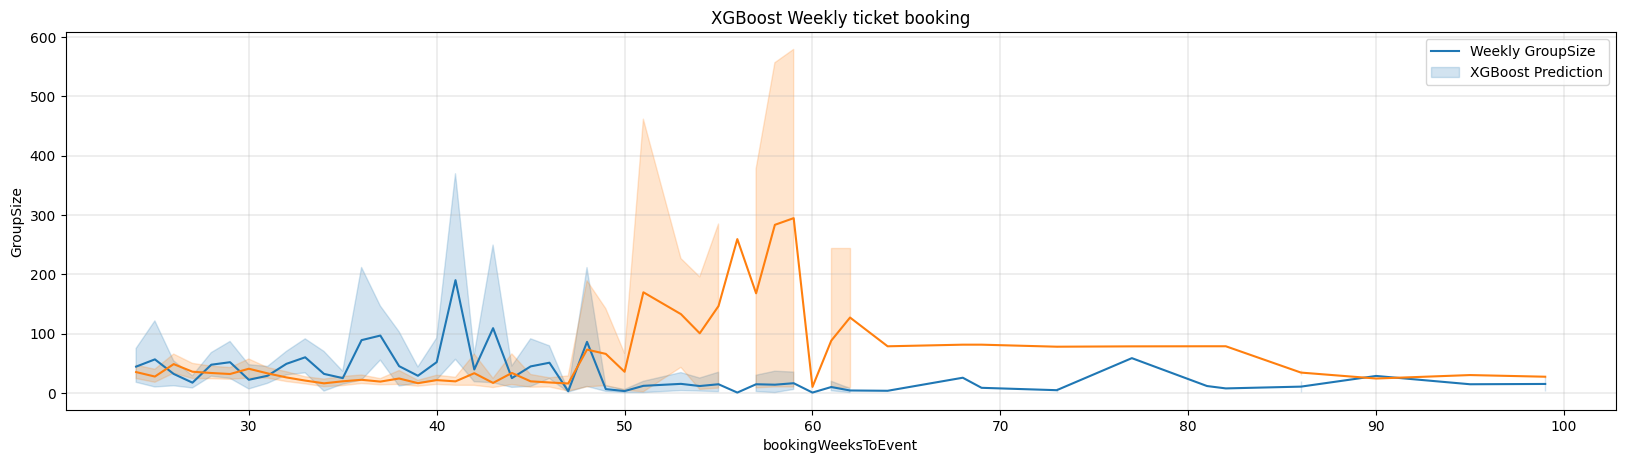

In [108]:
plt.figure(figsize=(20,5), dpi=100)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['GroupSize'], data=test)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['XGBoostWeeklyGroupSize'], data=test3)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weekly GroupSize","XGBoost Prediction"])
plt.title('XGBoost Weekly ticket booking')
ax.tick_params(axis='x', rotation=90)

Nueral Network for weekly booking

In [109]:
from keras.models import Sequential
from keras.layers import Dense

model3 = Sequential() 
model3.add(Dense(units=128, activation='relu'))  
model3.add(Dense(units=64, activation='relu')) 
model3.add(Dense(units=32, activation='relu')) 
model3.add(Dense(units=1))  
model3.compile('adam', loss='mse')  

history3 = model3.fit(X_train3, y_train3 , epochs=200) 
NNweeklybookingpredictions = model3.predict(X_test3)  

# print(NNweeklybookingpredictions)

Epoch 1/200
137/137 [==============================] - 1s 2ms/step - loss: 42464.2344
Epoch 2/200
137/137 [==============================] - 0s 2ms/step - loss: 39818.2148
Epoch 3/200
137/137 [==============================] - 0s 2ms/step - loss: 39477.1758
Epoch 4/200
137/137 [==============================] - 0s 2ms/step - loss: 39328.7656
Epoch 5/200
137/137 [==============================] - 0s 2ms/step - loss: 39231.6172
Epoch 6/200
137/137 [==============================] - 0s 2ms/step - loss: 39222.2695
Epoch 7/200
137/137 [==============================] - 0s 2ms/step - loss: 38708.3477
Epoch 8/200
137/137 [==============================] - 0s 2ms/step - loss: 38746.1641
Epoch 9/200
137/137 [==============================] - 0s 3ms/step - loss: 38660.7969
Epoch 10/200
137/137 [==============================] - 0s 3ms/step - loss: 38590.1758
Epoch 11/200
137/137 [==============================] - 0s 3ms/step - loss: 38421.6172
Epoch 12/200
137/137 [==============================

In [110]:
test3 = test3.reset_index().drop('index', axis=1)
test3['NNWeeklyGroupSize'] = pd.Series(NNweeklybookingpredictions.flatten())
data_table.DataTable(test3)

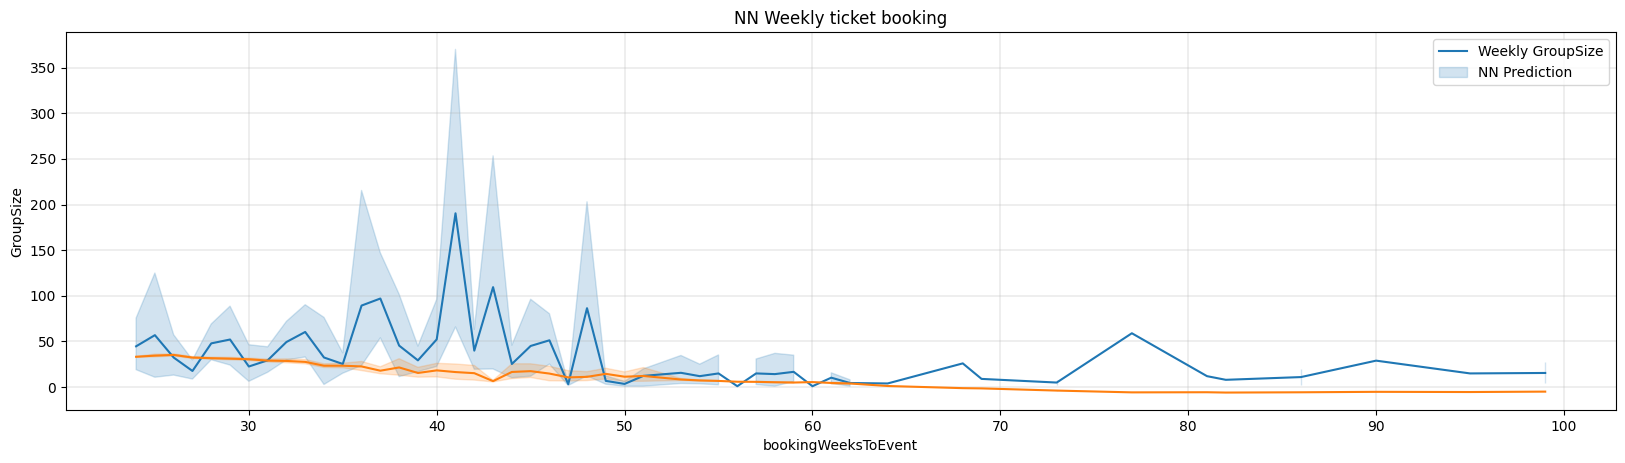

In [111]:
plt.figure(figsize=(20,5), dpi=100)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['GroupSize'], data=test)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['NNWeeklyGroupSize'], data=test3)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weekly GroupSize","NN Prediction"])
plt.title('NN Weekly ticket booking')
ax.tick_params(axis='x', rotation=90)

In [112]:
data_table.DataTable(test3)

# Random Forest Regressor

Total Ticket bookings

In [113]:
from sklearn.ensemble import RandomForestRegressor 

train4, test4 = train_test_split(result_df, shuffle=False, test_size=0.1)

X_train4 = train4.drop(labels=['TotalTickets', 'StartDate', 'Season', 'EventDate', 'EventId'  ], axis=1).reset_index()
y_train4 = train4['TotalTickets'].values 

X_test4 = test4.drop(labels=['TotalTickets', 'StartDate',  'Season', 'EventDate', 'EventId'  ], axis=1).reset_index()
y_test4 = test4['TotalTickets'].values 

regressor = RandomForestRegressor(n_estimators=20).fit(X_train4, y_train4)  
predictions4 = regressor.predict(X_test4)

# print(predictions4)

In [114]:
test4 = test4.reset_index().drop('index', axis=1)
test4['RFRTotalBookings'] = pd.Series(predictions4)
data_table.DataTable(test4)

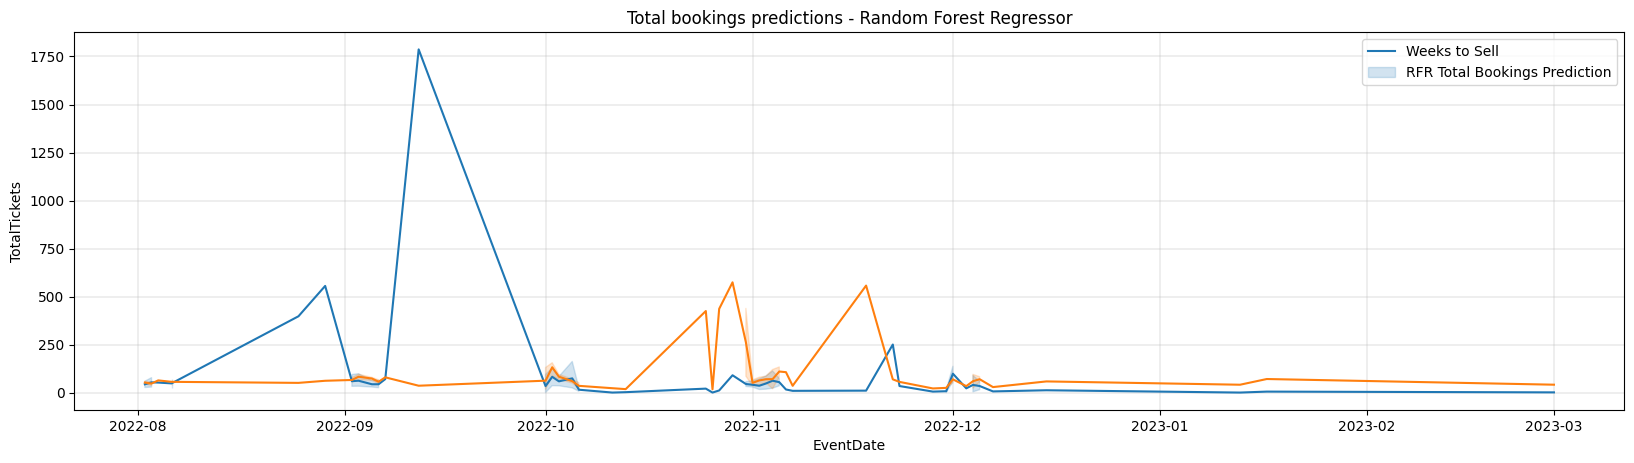

In [115]:
plt.figure(figsize=(20,5), dpi=100)
sns.lineplot(x=test4['EventDate'], y =test4['TotalTickets'], data=test)
sns.lineplot(x=test4['EventDate'], y =test4['RFRTotalBookings'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weeks to Sell","RFR Total Bookings Prediction"])
plt.title('Total bookings predictions - Random Forest Regressor')
ax.tick_params(axis='x', rotation=90)

Total booking weeks

In [116]:
#Using train and test 2 from above
regressor = RandomForestRegressor(n_estimators=20).fit(X_train2, y_train2)  
predictions5 = regressor.predict(X_test2)

In [117]:
test4 = test4.reset_index().drop('index', axis=1)
test4['RFRBookingWeeks'] = pd.Series(predictions5)
data_table.DataTable(test4)

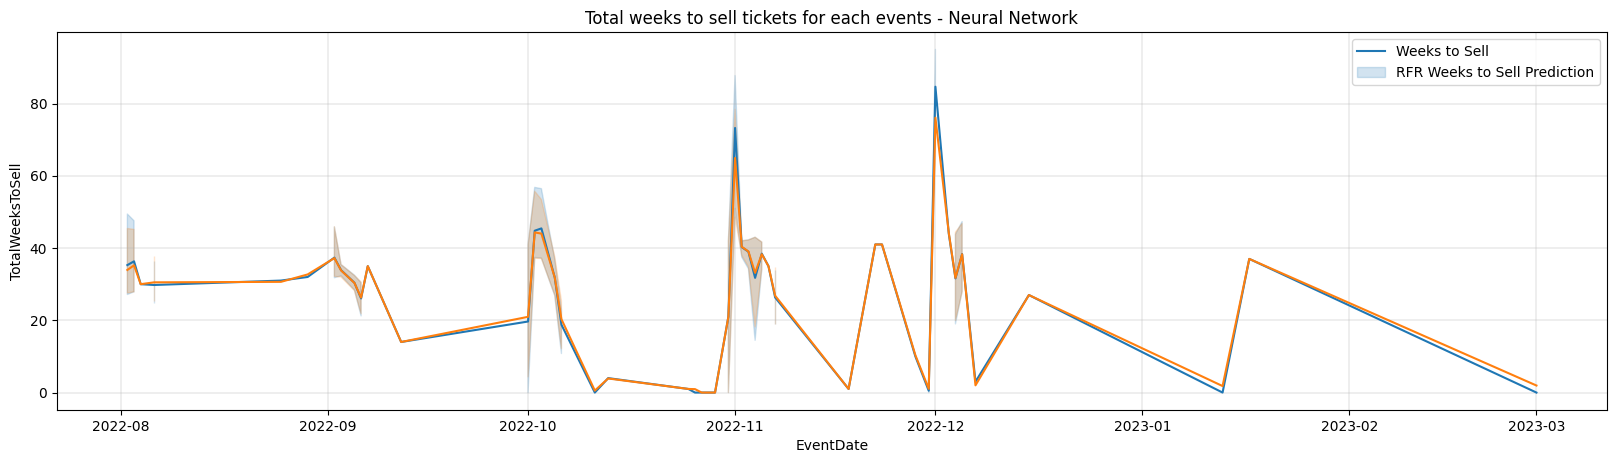

In [118]:
plt.figure(figsize=(20,5), dpi=100)
sns.lineplot(x=test4['EventDate'], y =test4['TotalWeeksToSell'], data=test)
sns.lineplot(x=test4['EventDate'], y =test4['RFRBookingWeeks'], data=test)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weeks to Sell","RFR Weeks to Sell Prediction"])
plt.title('Total weeks to sell tickets for each events - Neural Network')
ax.tick_params(axis='x', rotation=90)

Weekly Sales

In [119]:
#Using train and test 3 from above
regressor = RandomForestRegressor(n_estimators=20).fit(X_train3, y_train3)  
predictions6 = regressor.predict(X_test3)

In [120]:
test3 = test3.reset_index().drop('index', axis=1)
test3['RFRWeeklybookings'] = pd.Series(predictions6)
data_table.DataTable(test3)

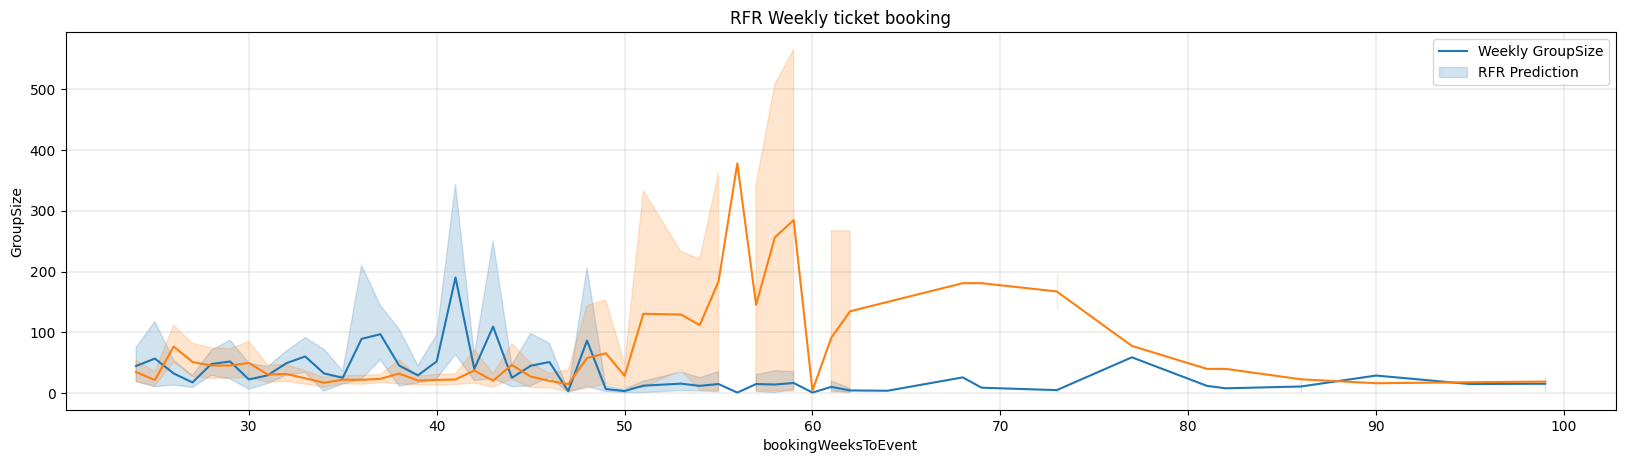

In [121]:
plt.figure(figsize=(20,5), dpi=100)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['GroupSize'], data=test)
sns.lineplot(x=test3['bookingWeeksToEvent'], y =test3['RFRWeeklybookings'], data=test3)

plt.grid(linestyle='-', linewidth=0.3)
plt.legend(labels=["Weekly GroupSize","RFR Prediction"])
plt.title('RFR Weekly ticket booking')
ax.tick_params(axis='x', rotation=90)